## Assignment 9: Supervised Learning Using H2o GBM, AutoML & Deep Learning Modules

The goal is to create model to identify loans potential for default. We will get a general understanding of the dataset and create relevant features that can be used later for efficient modeling. For this particular case we will aggregate the data to the loan_default level and card holder level then build various features.

## Data description
A Columbia partner firm has made its loans dataset available for research. The dataset contains 86 attributes with 80000 records.The data we are going to work on is the mortgage default dataset.The field 'loan_default' is the target variable. 

The objective of this problem is to predict loan default on the test set and present evaluation metrics such as ROC, Lift and Precision-Recall Curve. Cumulative lift is compared for different models from the gains chart and AUC(Area under curve) is measured for ROC curve and P-R curve. The models deployed are H2o's Gradient Boosting Machine & Deep Learning. Ensemle learning works best in cases where Type 1 and Type 2 errors render to be costly.

This assignment has the following components:
* Load and Clean the dataset
* Create and select essential features. Variable importance using the GBM Estimator gives us an idea of what variables to keep
* Testing the model on predefined hyperparameters
* Fine tune parameters by performing grid search and then re-running the model with the best parameters

In [1]:
import numpy as np
import plotly
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_f = pd.read_csv("XYZloan_default_selected_vars.csv")

In [3]:
data_f.dtypes

Unnamed: 0        int64
Unnamed: 0.1      int64
id                int64
loan_default      int64
AP001             int64
                 ...   
CD170           float64
CD172           float64
CD173           float64
MB005           float64
MB007            object
Length: 89, dtype: object

In [4]:
data_f['MB007'].unique()

array(['IPHONE7', 'WEB', 'OPPO', 'IPHONE8', 'IPHONE9', 'Noinfo', 'HUAWEI',
       'XIAOMI', 'GIONEE', 'VIVO', 'MEIZU', 'IPHONE6', 'IPHONE5', 'LEECO',
       'HONOR', 'SAMSUNG', '360', 'LETV', 'NUBIA', 'COOLPAD', 'IPAD4',
       'ZTE', 'IPAD6', 'IPHONE4', 'MEITU', 'ONEPLUS', 'LENOVO', 'IPAD3',
       'QIKU', 'LGE', 'PROTRULY', 'IPAD5', 'ZUK', 'DOOV', 'HISENSE',
       'SMARTISAN', 'XIAOLAJIAO', 'YUFLY', 'GOOGLE', 'CMDC', 'HTC', 'AND',
       'AMOI', 'KOPO', 'IVVI', 'NOKIA', 'YEPEN', 'SUGAR', 'SONY', 'ALPS',
       'CMCC', 'MANN', 'CHANGHONG', 'DAQ', 'IPOD7', 'PHILIPS', 'MOTOROLA',
       'ASUS', 'IPAD2', 'KOOBEE', 'SKYHON', 'SM-W2016', 'OWWO', 'VERIZON',
       '4G', 'MYTEL', 'YU-FLY', 'FOPAD', 'UOOGOU', 'SGMSGMS', 'KONKA',
       'BIFER', 'IPHONE3', 'TCL', 'GO', 'CHINAMOBILE', 'KINGSUN', 'KDDI',
       'ANDROID', 'ZUOKU', 'HMI', 'MLLED', 'HONGLAJIAO', 'VEGA', 'BIRD',
       'LINGWIN', 'TINAI', 'APPLE', 'VETAS', 'VOLTE', 'LEPHONE', 'REDGOO',
       'RAMOS', 'CONGMETAL', 'YTONE_L985', 'B

In [5]:
data_f['AP006'].unique()

array(['ios', 'h5', 'android', 'api'], dtype=object)

### Handling non-numeric data

In [6]:
obj = data_f.select_dtypes(include = ['object'])
obj.head(2)

,AP005,AP006,MB007
0,2017/7/6 10:21,ios,IPHONE7
1,2017/4/6 12:51,h5,WEB


In [7]:
obj["AP005"] =  pd.to_datetime(obj["AP005"])
obj['hour'] = obj['AP005'].dt.hour
obj['dayofweek'] = obj['AP005'].dt.dayofweek
obj['day'] = obj['AP005'].dt.day
obj['month'] = obj['AP005'].dt.month
obj['year'] = obj['AP005'].dt.year

<ipython-input-7-a41470806554>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj["AP005"] =  pd.to_datetime(obj["AP005"])
<ipython-input-7-a41470806554>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj['hour'] = obj['AP005'].dt.hour
<ipython-input-7-a41470806554>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [8]:
obj = obj.iloc[:,[3,4,5,6]]

In [9]:
obj

,hour,dayofweek,day,month
0,10,3,6,7
1,12,3,6,4
2,14,5,1,7
3,10,4,7,7
4,14,3,6,7
...,...,...,...,...
79995,13,6,7,5
79996,15,4,2,6
79997,8,6,9,7
79998,10,1,9,5


In [10]:
#obj = pd.get_dummies(obj)
#obj = obj[obj.columns[1:]]

In [11]:
df1 = pd.concat([data_f,obj],axis = 1)
df1.head(2)

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD169,CD170,CD172,CD173,MB005,MB007,hour,dayofweek,day,month
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7,10,3,6,7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,NaN,WEB,12,3,6,4


In [12]:
features = ['loan_default','AP001','AP002','AP003','AP004','AP007','AP008','AP009','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014','TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029','CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','PA022','PA023','PA028','PA029','PA030','PA031','CD008','CD018','CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113','CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131','CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164','CD166','CD167','CD169','CD170','CD172','CD173','MB005','hour','dayofweek','day','month']
df = df1[features]

#### Check for missing values

In [13]:
missing_values = df.isnull().sum()
missing_values_per = (df.isnull().sum() / df.isnull().count())
pd.concat([missing_values, missing_values_per],axis=1, keys = ['Count_of_Missing','Percentage'])

,Count_of_Missing,Percentage
loan_default,0,0.000000
AP001,0,0.000000
AP002,0,0.000000
AP003,0,0.000000
AP004,0,0.000000
...,...,...
MB005,2793,0.034912
hour,0,0.000000
dayofweek,0,0.000000
day,0,0.000000


#### Filling in missing data

In [14]:
for col in features:
    df.loc[:,col].fillna(df.loc[:,col].mean(),inplace=True)

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Section 2: Weight of Evidence (WOE) ENCODING
##### Weight of evidence (WOE) is a widely used technique in credit risk modeling or called the probability of default modeling (such models predict how capable an applicant is able to repay the loan).

The goal of such transformation is to get the maximum difference among the binned categories relating to the target variable. It counts the number of responders and non-responders in each binned categories, then assigns a numeric value to each of the binned categories. 

In [15]:
def WOE(var):
    try:
        df[var] = df[var].fillna('NoData')
    except:
        pass
    k = df[[var,'loan_default']].groupby(var)['loan_default'].agg(['count','sum']).reset_index()
    k.columns = [var,'Count','Bad']
    k['Good'] = k['Count'] - k['Bad']
    k['Good %'] = (k['Good'] / k['Good'].sum()*100).round(2)
    k['Bad %'] = (k['Bad'] / k['Bad'].sum()*100).round(2)
    ratio = k['Good %'] / k['Bad %']
    k[var+'_WOE'] = np.log(ratio).round(2)
    k = k.sort_values(by=var+'_WOE')
    return(k)

In [16]:
for i in features[1:]:
    var = i
    binned_var = var + '_D'
    percentile = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
    df[binned_var] = pd.qcut( df[var],percentile,duplicates='drop')

<ipython-input-16-c5aca2ea478b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[binned_var] = pd.qcut( df[var],percentile,duplicates='drop')
<ipython-input-16-c5aca2ea478b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[binned_var] = pd.qcut( df[var],percentile,duplicates='drop')
<ipython-input-16-c5aca2ea478b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [17]:
features1 = ['AP001_D','AP002_D','AP003_D','AP004_D','AP007_D','AP008_D','AP009_D','TD001_D','TD002_D','TD005_D','TD006_D','TD009_D','TD010_D','TD013_D','TD014_D','TD015_D','TD022_D','TD023_D','TD024_D','TD025_D','TD026_D','TD027_D','TD028_D','TD029_D','CR004_D','CR005_D','CR009_D','CR012_D','CR015_D','CR017_D','CR018_D','CR019_D','PA022_D','PA023_D','PA028_D','PA029_D','PA030_D','PA031_D','CD008_D','CD018_D','CD071_D','CD072_D','CD088_D','CD100_D','CD101_D','CD106_D','CD107_D','CD108_D','CD113_D','CD114_D','CD115_D','CD117_D','CD118_D','CD120_D','CD121_D','CD123_D','CD130_D','CD131_D','CD132_D','CD133_D','CD135_D','CD136_D','CD137_D','CD152_D','CD153_D','CD160_D','CD162_D','CD164_D','CD166_D','CD167_D','CD169_D','CD170_D','CD172_D','CD173_D','MB005_D','hour','dayofweek','day','month']

<ipython-input-18-4dd47e55297f>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


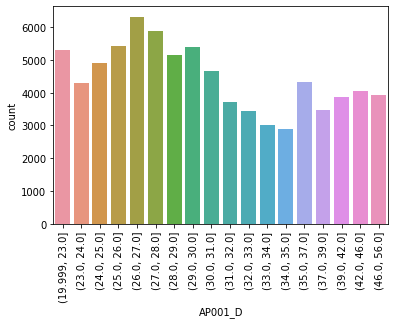

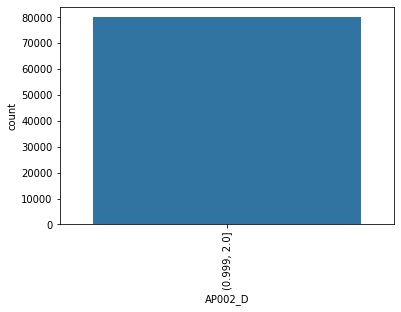

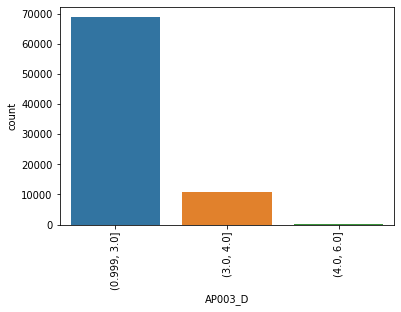

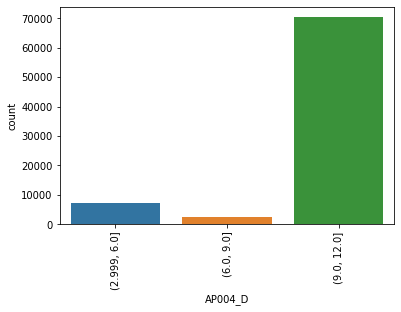

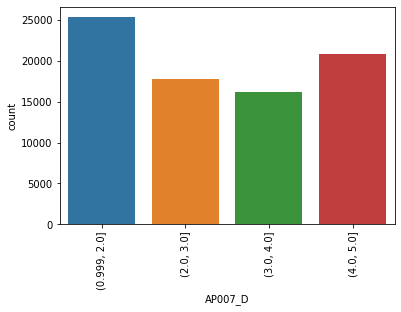

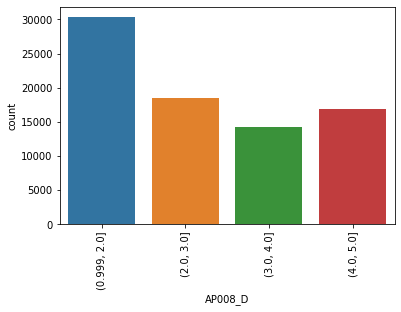

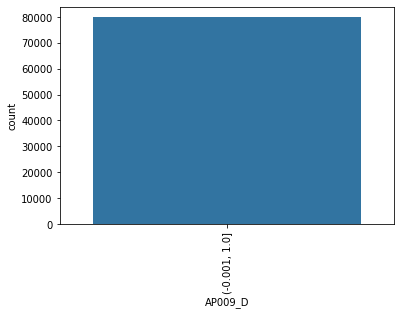

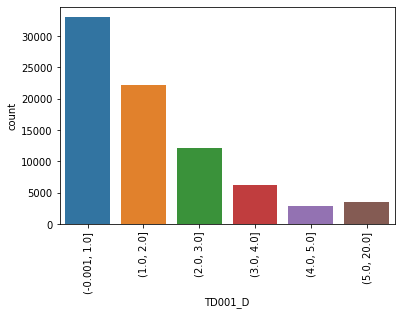

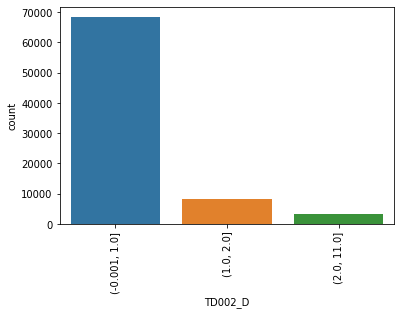

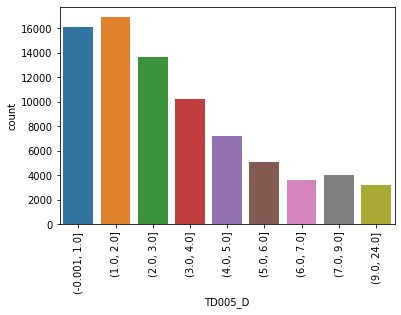

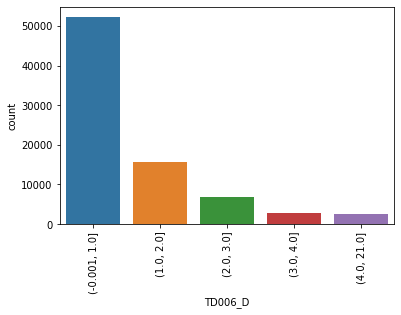

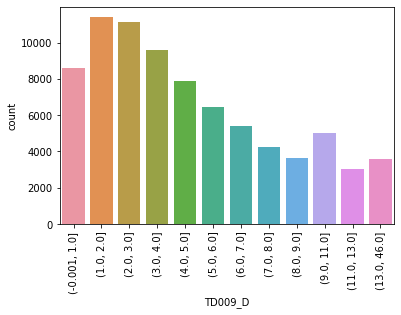

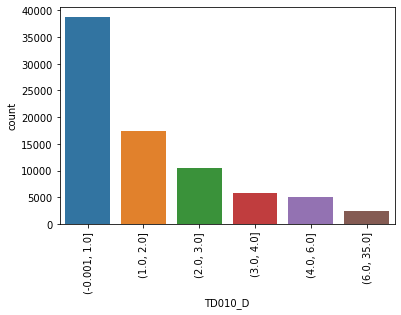

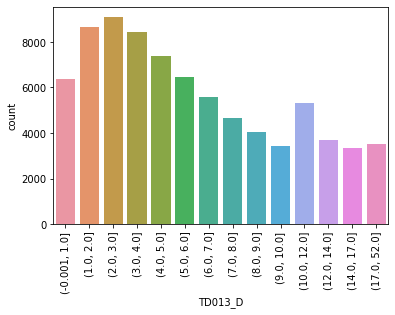

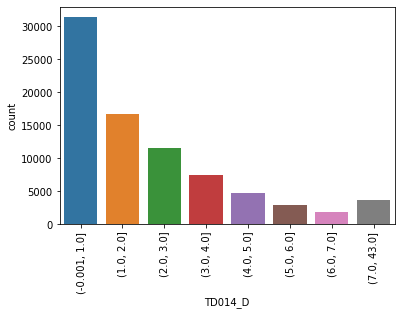

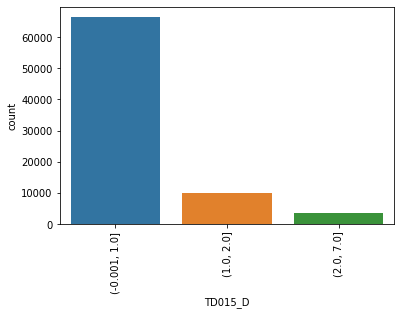

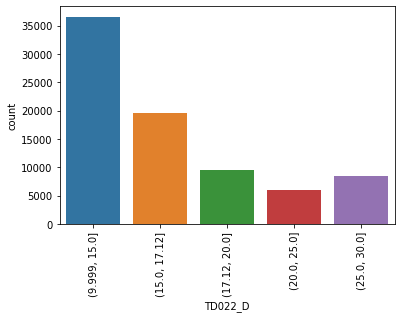

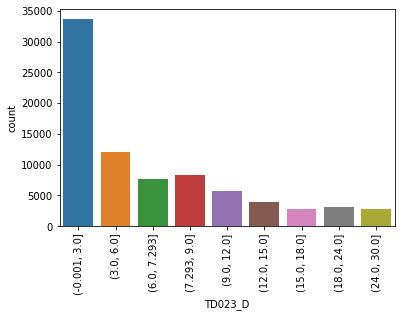

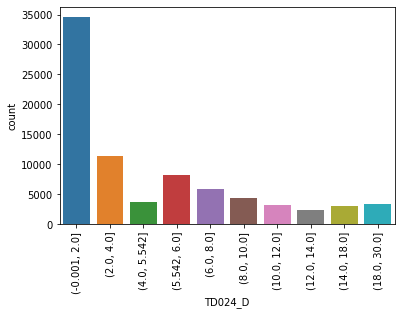

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

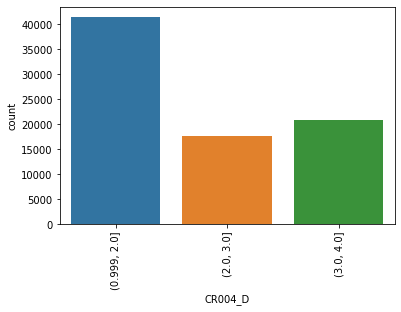

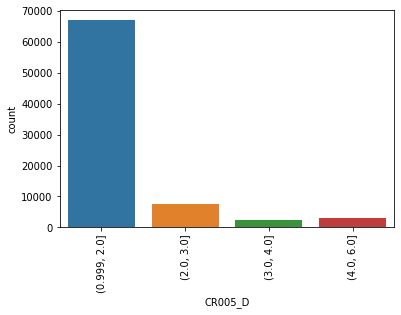

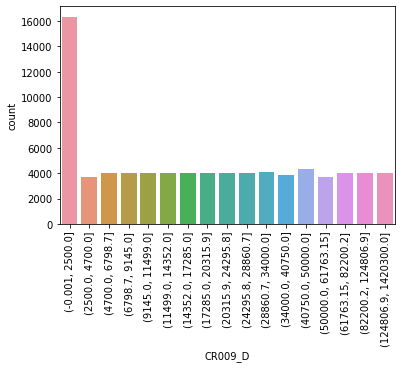

<Figure size 432x288 with 0 Axes>

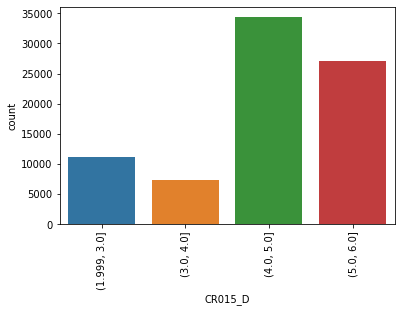

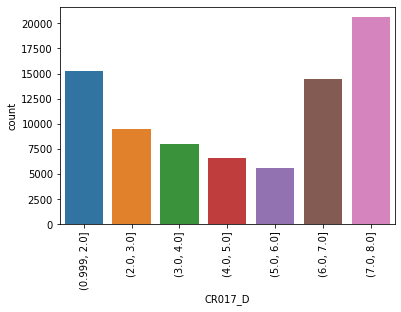

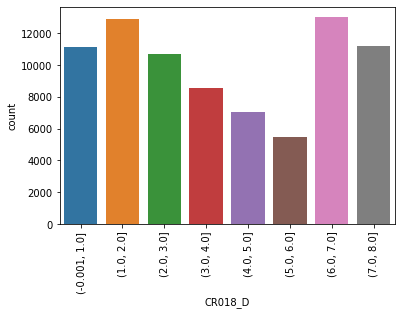

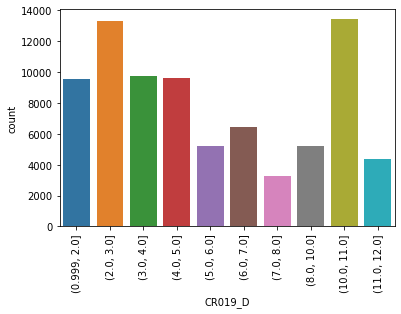

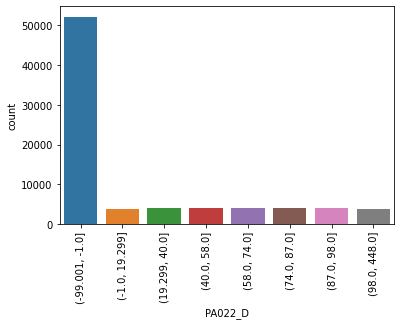

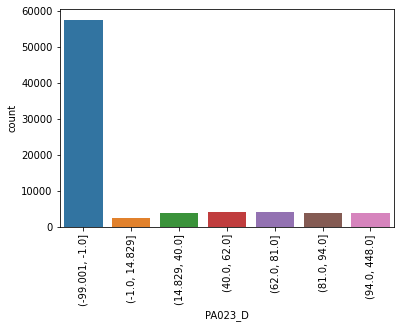

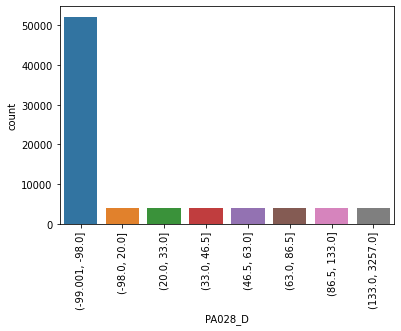

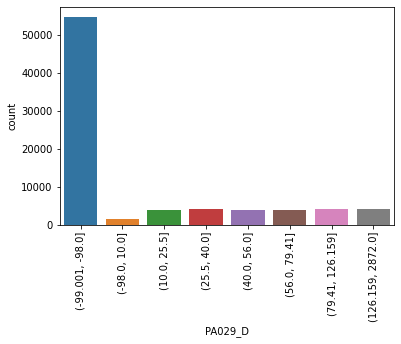

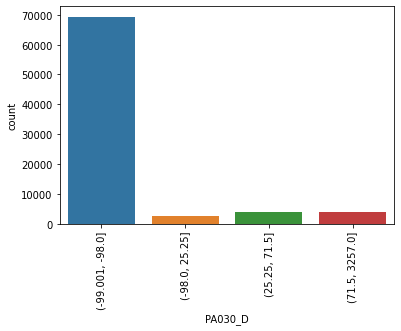

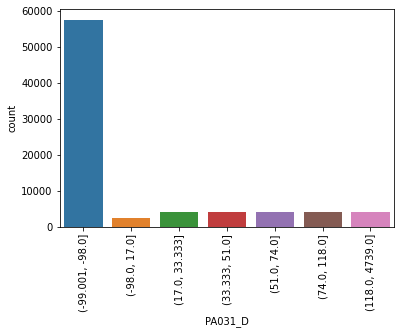

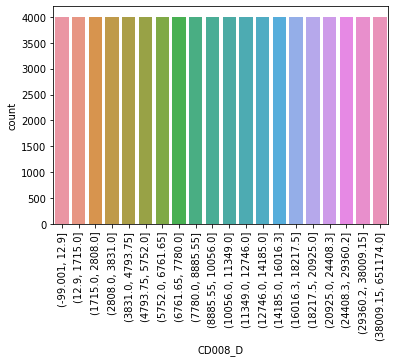

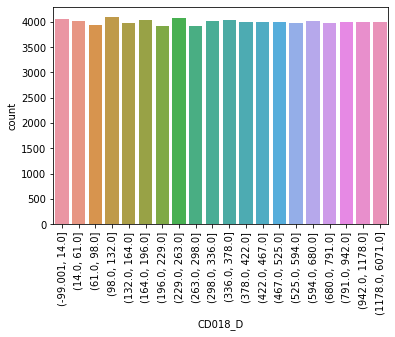

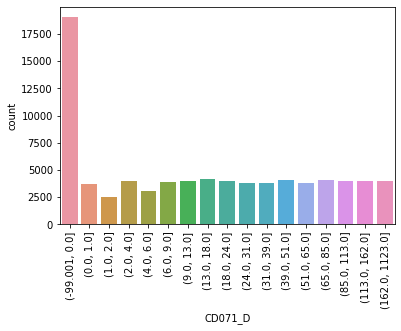

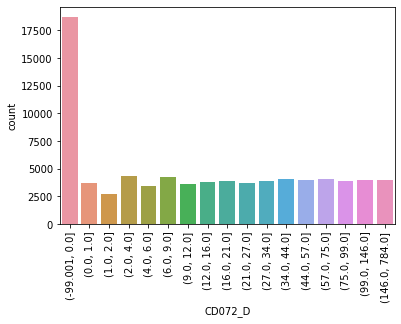

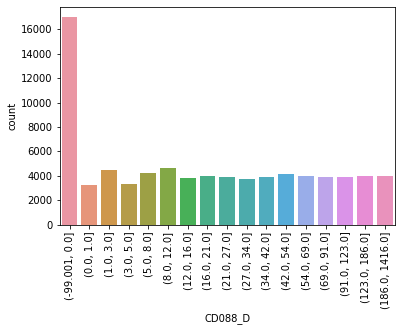

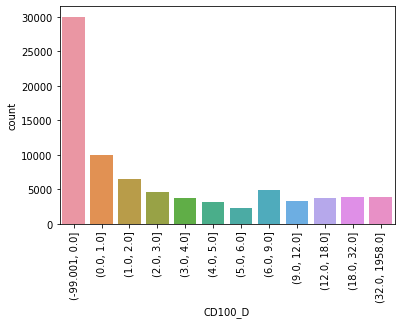

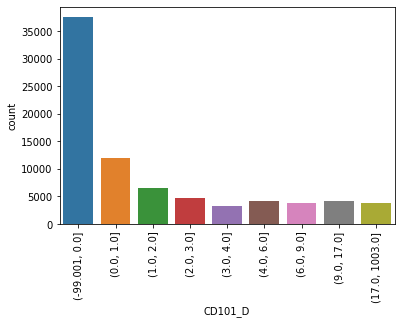

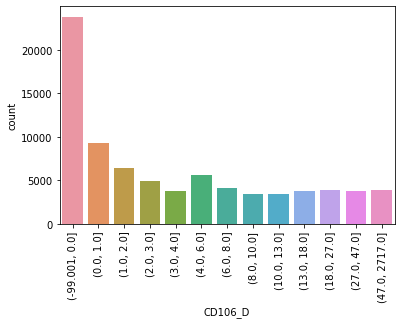

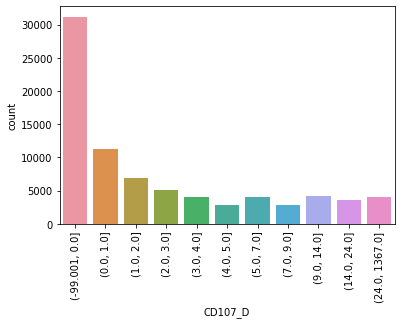

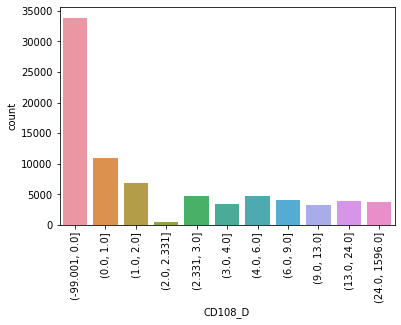

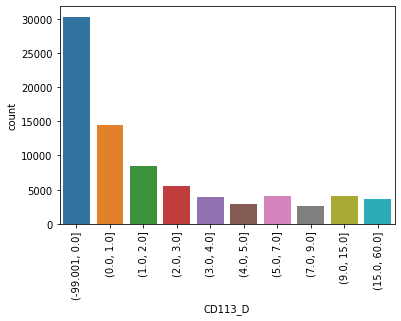

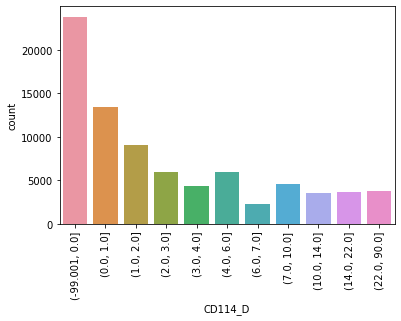

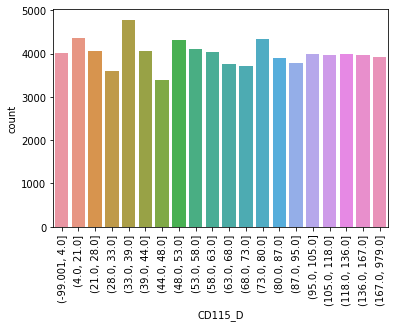

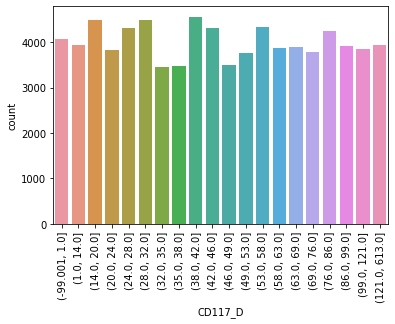

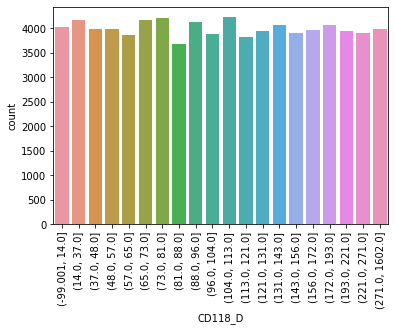

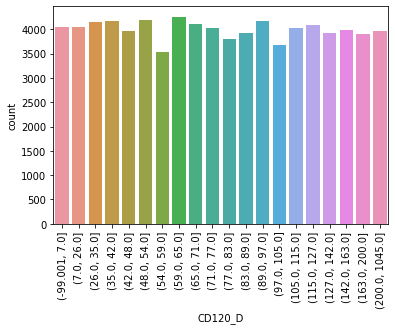

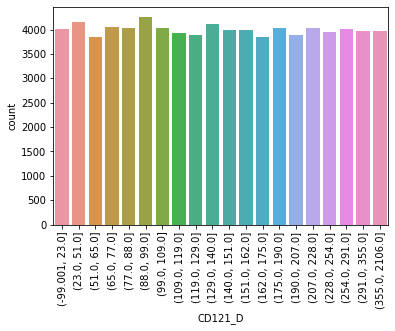

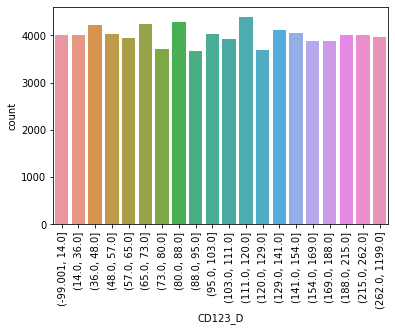

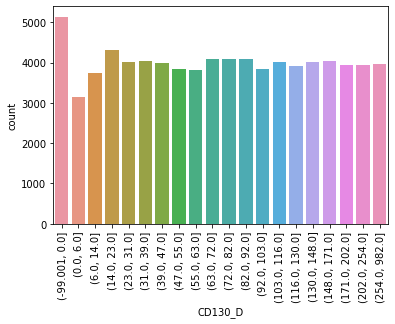

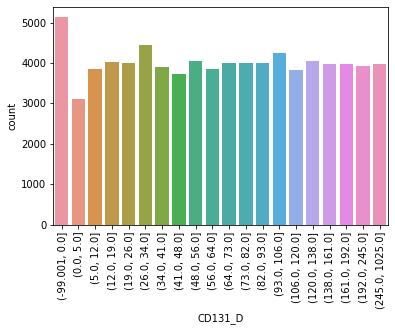

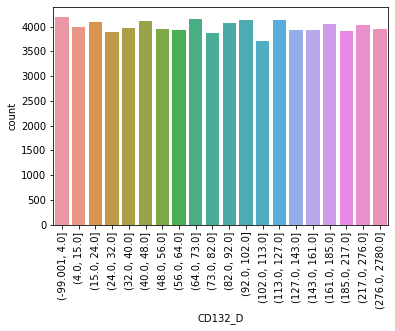

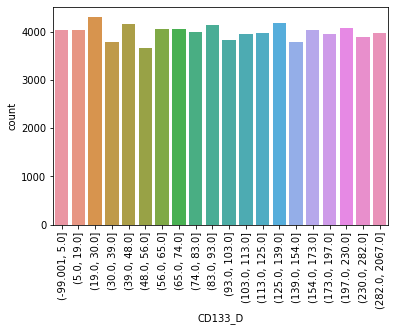

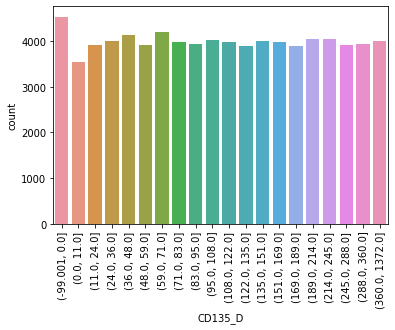

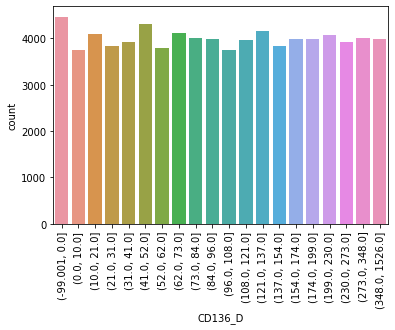

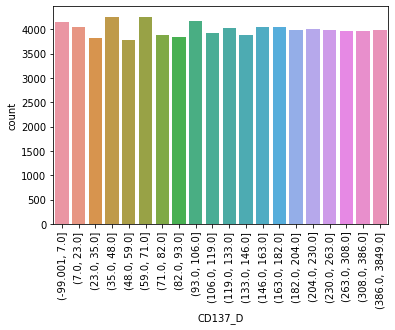

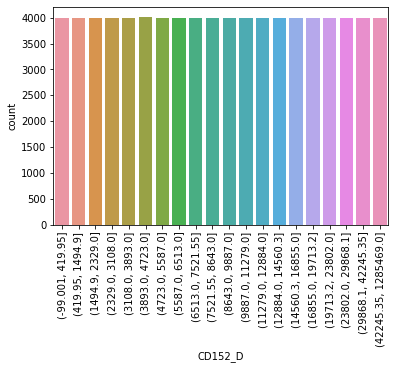

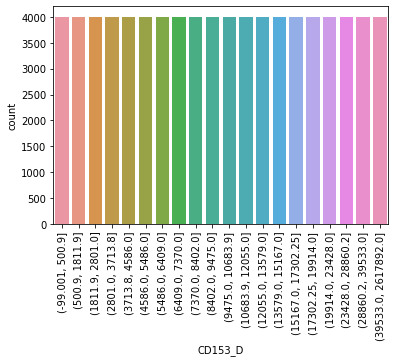

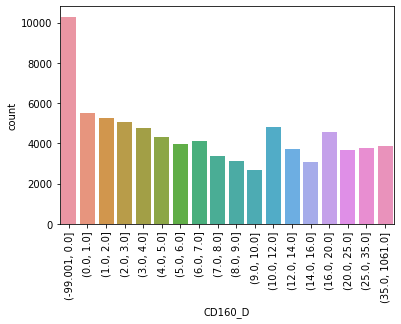

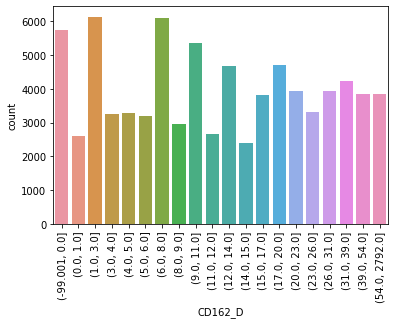

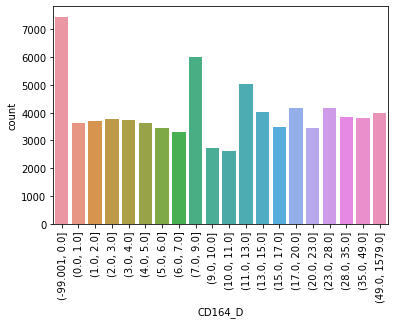

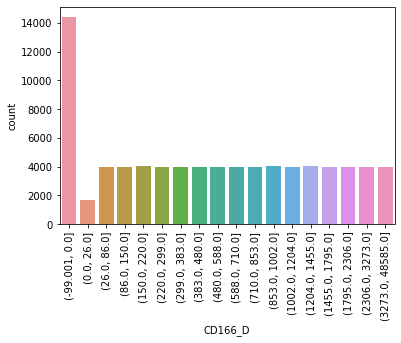

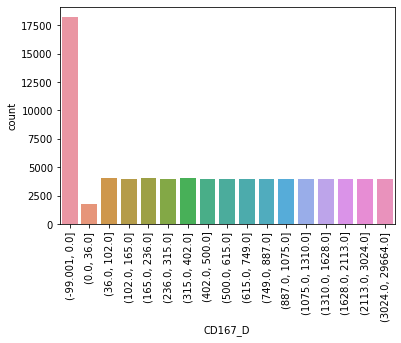

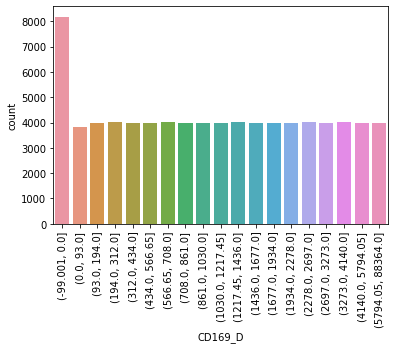

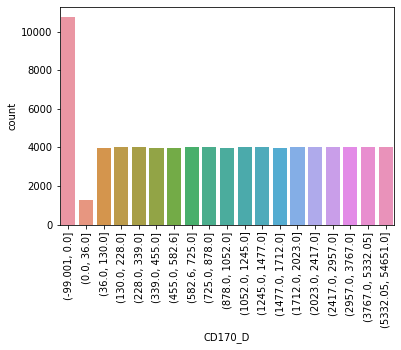

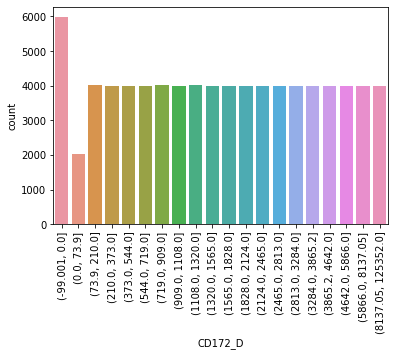

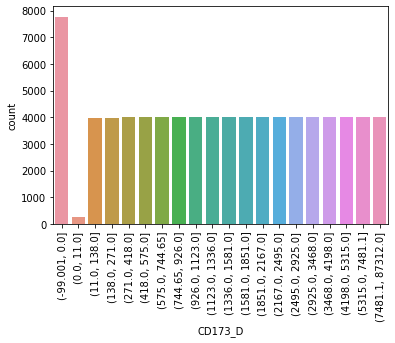

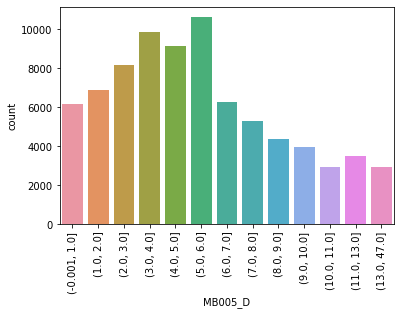

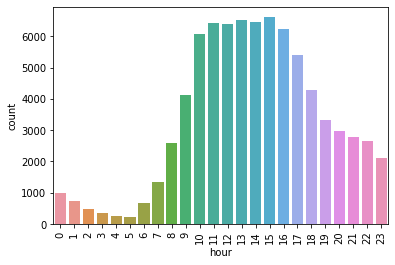

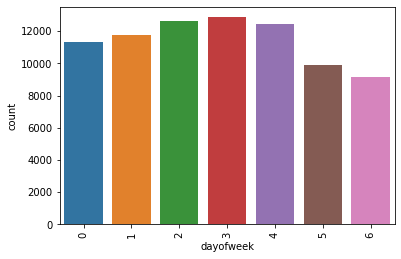

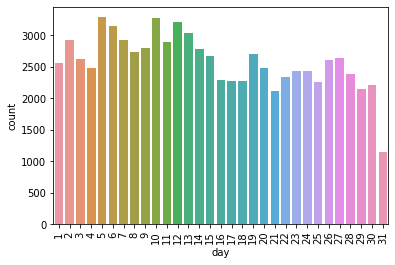

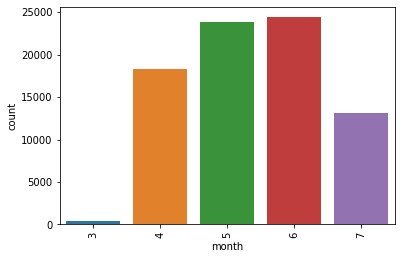

In [18]:
for i in features1:
    try:
        plt.figure(figsize=(6,4))
        g = sns.countplot(x=i, data=df)
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    except:
        pass

### Passing the Bins attributes to WOE function to create respective weights

In [19]:
for f in features1:
    try:
        k = WOE(f)
        df = pd.merge(df,k[[f,f+'_WOE']], left_on=f, right_on=f,how='left')
    except:
        pass

In [20]:
df.describe()

,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,TD002,...,CD167_D_WOE,CD169_D_WOE,CD170_D_WOE,CD172_D_WOE,CD173_D_WOE,MB005_D_WOE,hour_WOE,dayofweek_WOE,day_WOE,month_WOE
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,0.727925,1.986962,0.706213,...,0.000571,0.003320,0.002369,0.002508,0.00267,0.010630,0.000217,-0.000353,0.000532,0.002163
std,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,0.445031,1.807445,0.918347,...,0.082500,0.099453,0.103636,0.098480,0.09896,0.182356,0.061067,0.023721,0.063353,0.086492
min,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,0.000000,...,-0.200000,-0.190000,-0.190000,-0.160000,-0.17000,-0.270000,-0.410000,-0.040000,-0.200000,-0.100000
25%,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,0.000000,1.000000,0.000000,...,-0.030000,-0.070000,-0.080000,-0.080000,-0.07000,-0.160000,-0.020000,0.000000,-0.030000,-0.050000
50%,0.000000,30.000000,1.000000,1.000000,12.000000,3.00000,3.000000,1.000000,2.000000,0.000000,...,-0.010000,0.010000,0.000000,0.020000,0.02000,-0.010000,-0.010000,-0.000000,-0.000000,-0.050000
75%,0.000000,35.000000,2.000000,3.000000,12.000000,5.00000,4.000000,1.000000,3.000000,1.000000,...,0.090000,0.100000,0.080000,0.080000,0.07000,0.080000,0.020000,0.010000,0.040000,0.050000
max,1.000000,56.000000,2.000000,6.000000,12.000000,5.00000,5.000000,1.000000,20.000000,11.000000,...,0.100000,0.150000,0.160000,0.170000,0.17000,0.490000,0.160000,0.040000,0.130000,0.150000


In [21]:
features2 = ['AP001_D_WOE','AP002_D_WOE','AP003_D_WOE','AP004_D_WOE','AP007_D_WOE','AP008_D_WOE','AP009_D_WOE','TD001_D_WOE','TD002_D_WOE','TD005_D_WOE','TD006_D_WOE','TD009_D_WOE','TD010_D_WOE','TD013_D_WOE','TD014_D_WOE','TD015_D_WOE','TD022_D_WOE','TD023_D_WOE','TD024_D_WOE','TD025_D_WOE','TD026_D_WOE','TD027_D_WOE','TD028_D_WOE','TD029_D_WOE','CR004_D_WOE','CR005_D_WOE','CR009_D_WOE','CR012_D_WOE','CR015_D_WOE','CR017_D_WOE','CR018_D_WOE','CR019_D_WOE','PA022_D_WOE','PA023_D_WOE','PA028_D_WOE','PA029_D_WOE','PA030_D_WOE','PA031_D_WOE','CD008_D_WOE','CD018_D_WOE','CD071_D_WOE','CD072_D_WOE','CD088_D_WOE','CD100_D_WOE','CD101_D_WOE','CD106_D_WOE','CD107_D_WOE','CD108_D_WOE','CD113_D_WOE','CD114_D_WOE','CD115_D_WOE','CD117_D_WOE','CD118_D_WOE','CD120_D_WOE','CD121_D_WOE','CD123_D_WOE','CD130_D_WOE','CD131_D_WOE','CD132_D_WOE','CD133_D_WOE','CD135_D_WOE','CD136_D_WOE','CD137_D_WOE','CD152_D_WOE','CD153_D_WOE','CD160_D_WOE','CD162_D_WOE','CD164_D_WOE','CD166_D_WOE','CD167_D_WOE','CD169_D_WOE','CD170_D_WOE','CD172_D_WOE','CD173_D_WOE','MB005_D_WOE','hour_WOE','dayofweek_WOE','day_WOE','month_WOE']

### Importing H2O

In [22]:
#importing h20 and intiating
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.12+8-LTS-237, mixed mode)
  Starting server from C:\Users\Varadharajan Suresh\AppData\Local\Programs\Python\Python39\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\VARADH~1\AppData\Local\Temp\tmpuwgjh0ke
  JVM stdout: C:\Users\VARADH~1\AppData\Local\Temp\tmpuwgjh0ke\h2o_Varadharajan_Suresh_started_from_python.out
  JVM stderr: C:\Users\VARADH~1\AppData\Local\Temp\tmpuwgjh0ke\h2o_Varadharajan_Suresh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_Varadharajan_Suresh_etxb77
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.938 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [23]:
#importing h2o estimators gradient boosting and other packages
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from sklearn.model_selection import train_test_split

In [24]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

In [25]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

In [26]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

### H2o's Gradient Boosting Machine
Gradient Boosting Machine (for Regression and Classification) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations. H2O’s GBM sequentially builds regression trees on all the features of the dataset in a fully distributed way - each tree is built in parallel.

#### Modeling best practices
When you model, you should run with a small sample dataset
Try to write repeating code in a function


#### Model 0: using all the raw features 10% of data

In [240]:
target = 'loan_default'
predictors = ['AP001','AP002','AP003','AP004','AP007','AP008','AP009','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014','TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029','CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','PA022','PA023','PA028','PA029','PA030','PA031','CD008','CD018','CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113','CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131','CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164','CD166','CD167','CD169','CD170','CD172','CD173','MB005','hour','dayofweek','day','month']

In [91]:
train, test = train_test_split(df, test_size=0.40, random_state=414)
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [93]:
gbm_v0 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v0',
        ntrees = 300,
        nfolds=10,
        min_rows=20,
        sample_rate=0.70,
        seed=1234)
gbm_v0.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [TD029, TD028, TD027, TD026, TD025, CR012]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_v0


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,300.0,300.0,84239.0,5.0,5.0,5.0,7.0,30.0,17.603333




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.048956673645671515
RMSE: 0.22126155031019626
MAE: 0.1628134489401085
RMSLE: 0.15317803643552866
Mean Residual Deviance: 0.048956673645671515

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.15700492296491095
RMSE: 0.39623846729578255
MAE: 0.29795846426554456
RMSLE: 0.2825098737461791
Mean Residual Deviance: 0.15700492296491095

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.298253,0.013569,0.326554,0.294947,0.297959,0.305671,0.301532,0.274370,0.306063,0.294963,0.292310,0.288165
1,mean_residual_deviance,0.157323,0.011934,0.181692,0.154104,0.155873,0.162587,0.163605,0.135178,0.163554,0.152698,0.152389,0.151550
2,mse,0.157323,0.011934,0.181692,0.154104,0.155873,0.162587,0.163605,0.135178,0.163554,0.152698,0.152389,0.151550
3,r2,-0.002303,0.056327,-0.033950,-0.101240,-0.039056,0.035277,-0.008764,0.059089,-0.045863,0.050460,-0.016166,0.077180
4,residual_deviance,0.157323,0.011934,0.181692,0.154104,0.155873,0.162587,0.163605,0.135178,0.163554,0.152698,0.152389,0.151550
5,rmse,0.396384,0.015014,0.426254,0.392560,0.394808,0.403221,0.404481,0.367666,0.404419,0.390766,0.390370,0.389295
6,rmsle,0.282506,0.010333,0.301188,0.285724,0.283694,0.286361,0.287804,0.262269,0.287834,0.277499,0.279371,0.273322



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-11-27 19:38:41,30.798 sec,0.0,0.396201,0.313950,0.156975
1,,2021-11-27 19:38:41,30.820 sec,1.0,0.392747,0.310912,0.154250
2,,2021-11-27 19:38:41,30.829 sec,2.0,0.389651,0.308126,0.151828
3,,2021-11-27 19:38:41,30.829 sec,3.0,0.387189,0.305657,0.149915
4,,2021-11-27 19:38:41,30.845 sec,4.0,0.385234,0.303496,0.148405
5,,2021-11-27 19:38:41,30.845 sec,5.0,0.382860,0.301306,0.146581
6,,2021-11-27 19:38:41,30.861 sec,6.0,0.380736,0.299424,0.144960
7,,2021-11-27 19:38:41,30.876 sec,7.0,0.379213,0.297929,0.143802
8,,2021-11-27 19:38:41,30.876 sec,8.0,0.377092,0.295648,0.142199
9,,2021-11-27 19:38:41,30.895 sec,9.0,0.375582,0.293894,0.141062



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD005,103.814285,1.000000,0.034662
1,CD123,85.229012,0.820976,0.028456
2,day,78.334000,0.754559,0.026154
3,MB005,72.261360,0.696064,0.024127
4,TD009,71.898094,0.692565,0.024006
5,TD013,65.448654,0.630440,0.021852
6,CD071,63.792427,0.614486,0.021299
7,AP001,63.655884,0.613171,0.021254
8,CD120,62.656353,0.603543,0.020920
9,CD008,60.943657,0.587045,0.020348



See the whole table with table.as_data_frame()


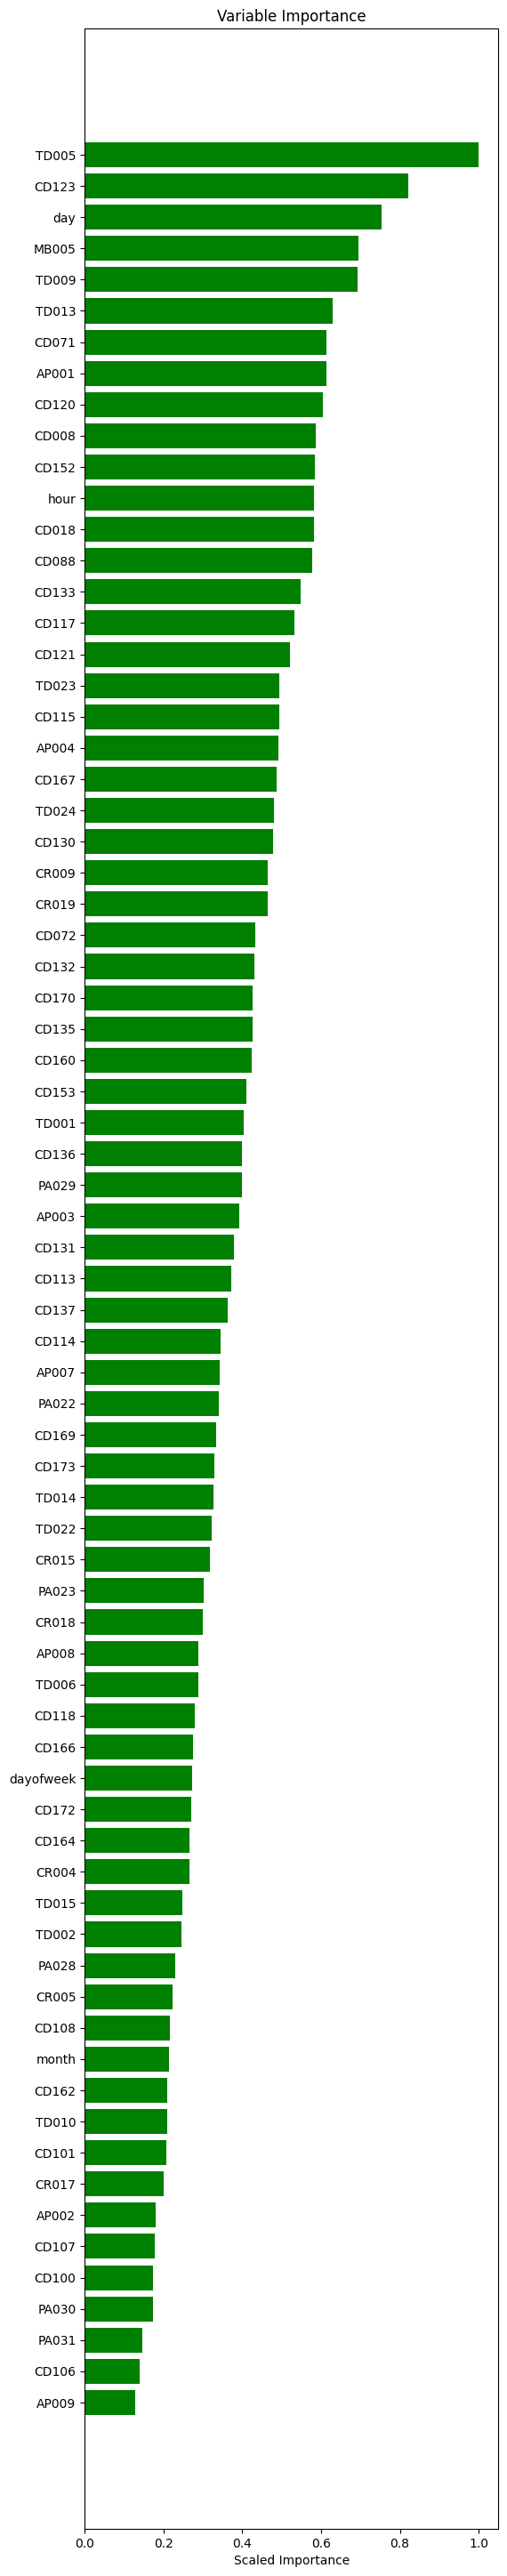

In [94]:
VarImp(gbm_v0)

In [95]:
createGains(gbm_v0)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,111,209,320,111,209,0.18,0.08,61.3,1.81,10.0,34.69
1,320,100,220,640,211,429,0.34,0.17,122.6,1.72,17.0,32.97
2,320,67,253,960,278,682,0.45,0.26,183.9,1.51,19.0,28.96
3,320,65,255,1280,343,937,0.56,0.36,245.2,1.40,20.0,26.80
4,320,71,249,1600,414,1186,0.68,0.46,306.5,1.35,22.0,25.87
5,320,55,265,1920,469,1451,0.77,0.56,367.8,1.28,21.0,24.43
6,320,34,286,2240,503,1737,0.82,0.67,429.1,1.17,15.0,22.46
7,320,38,282,2560,541,2019,0.88,0.78,490.4,1.10,10.0,21.13
8,320,38,282,2880,579,2301,0.94,0.89,551.7,1.05,5.0,20.10


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



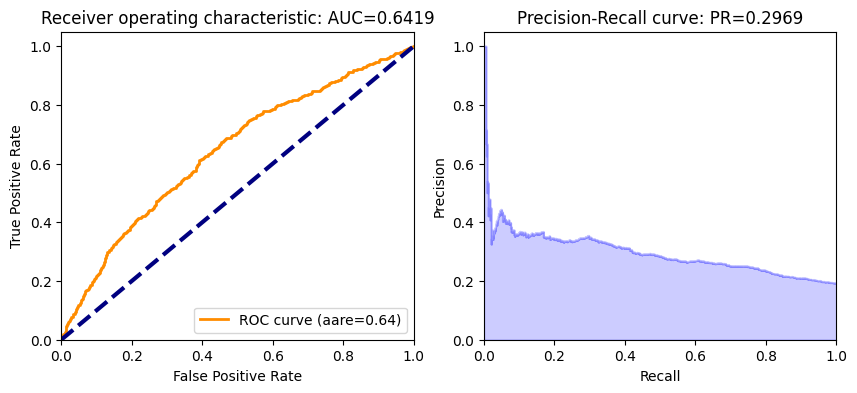

In [96]:
ROC_AUC(gbm_v0,test_hex,'loan_default')

In [246]:
createGains(gbm_v0)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1104,2096,3200,1104,2096,0.18,0.08,616.2,1.79,10.0,34.50
1,3200,906,2294,6400,2010,4390,0.33,0.17,1232.4,1.63,16.0,31.41
2,3200,712,2488,9600,2722,6878,0.44,0.27,1848.6,1.47,17.0,28.35
3,3200,699,2501,12800,3421,9379,0.56,0.36,2464.8,1.39,20.0,26.73
4,3200,625,2575,16000,4046,11954,0.66,0.46,3081.0,1.31,20.0,25.29
5,3200,570,2630,19200,4616,14584,0.75,0.56,3697.2,1.25,19.0,24.04
6,3200,479,2721,22400,5095,17305,0.83,0.67,4313.4,1.18,16.0,22.75
7,3200,418,2782,25600,5513,20087,0.89,0.78,4929.6,1.12,11.0,21.54
8,3200,363,2837,28800,5876,22924,0.95,0.89,5545.8,1.06,6.0,20.40


#### Model 1: using all the raw features

In [241]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [242]:
gbm_v1 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v1',
        #ntrees = 300,
        #nfolds=10,
        #min_rows=20,
        #sample_rate=0.70,
        seed=1234)
gbm_v1.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [TD029, TD028, TD027, TD026, TD025, CR012]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_v1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22127.0,5.0,5.0,5.0,25.0,32.0,30.52




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.1372821116283471
RMSE: 0.3705160072498179
MAE: 0.28385370685739814
RMSLE: 0.25895175696488526
Mean Residual Deviance: 0.1372821116283471

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-11-27 20:46:38,0.000 sec,0.0,0.395654,0.313085,0.156542
1,,2021-11-27 20:46:38,0.336 sec,1.0,0.393667,0.311434,0.154974
2,,2021-11-27 20:46:38,0.384 sec,2.0,0.391985,0.309924,0.153653
3,,2021-11-27 20:46:38,0.436 sec,3.0,0.390558,0.308551,0.152536
4,,2021-11-27 20:46:38,0.500 sec,4.0,0.389334,0.307291,0.151581
5,,2021-11-27 20:46:38,0.551 sec,5.0,0.388216,0.306102,0.150712
6,,2021-11-27 20:46:38,0.674 sec,6.0,0.387230,0.305008,0.149947
7,,2021-11-27 20:46:38,0.721 sec,7.0,0.386355,0.304013,0.149271
8,,2021-11-27 20:46:39,0.790 sec,8.0,0.385563,0.303104,0.148659
9,,2021-11-27 20:46:39,0.843 sec,9.0,0.384750,0.302157,0.148033



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,604.112793,1.000000,0.124135
1,AP004,520.429382,0.861477,0.106939
2,AP003,477.044098,0.789661,0.098024
3,TD009,205.033401,0.339396,0.042131
4,MB005,199.340958,0.329973,0.040961
5,TD005,193.529587,0.320353,0.039767
6,CR015,176.161804,0.291604,0.036198
7,CD123,163.319519,0.270346,0.033559
8,CD114,124.978363,0.206879,0.025681
9,PA029,107.426308,0.177825,0.022074



See the whole table with table.as_data_frame()


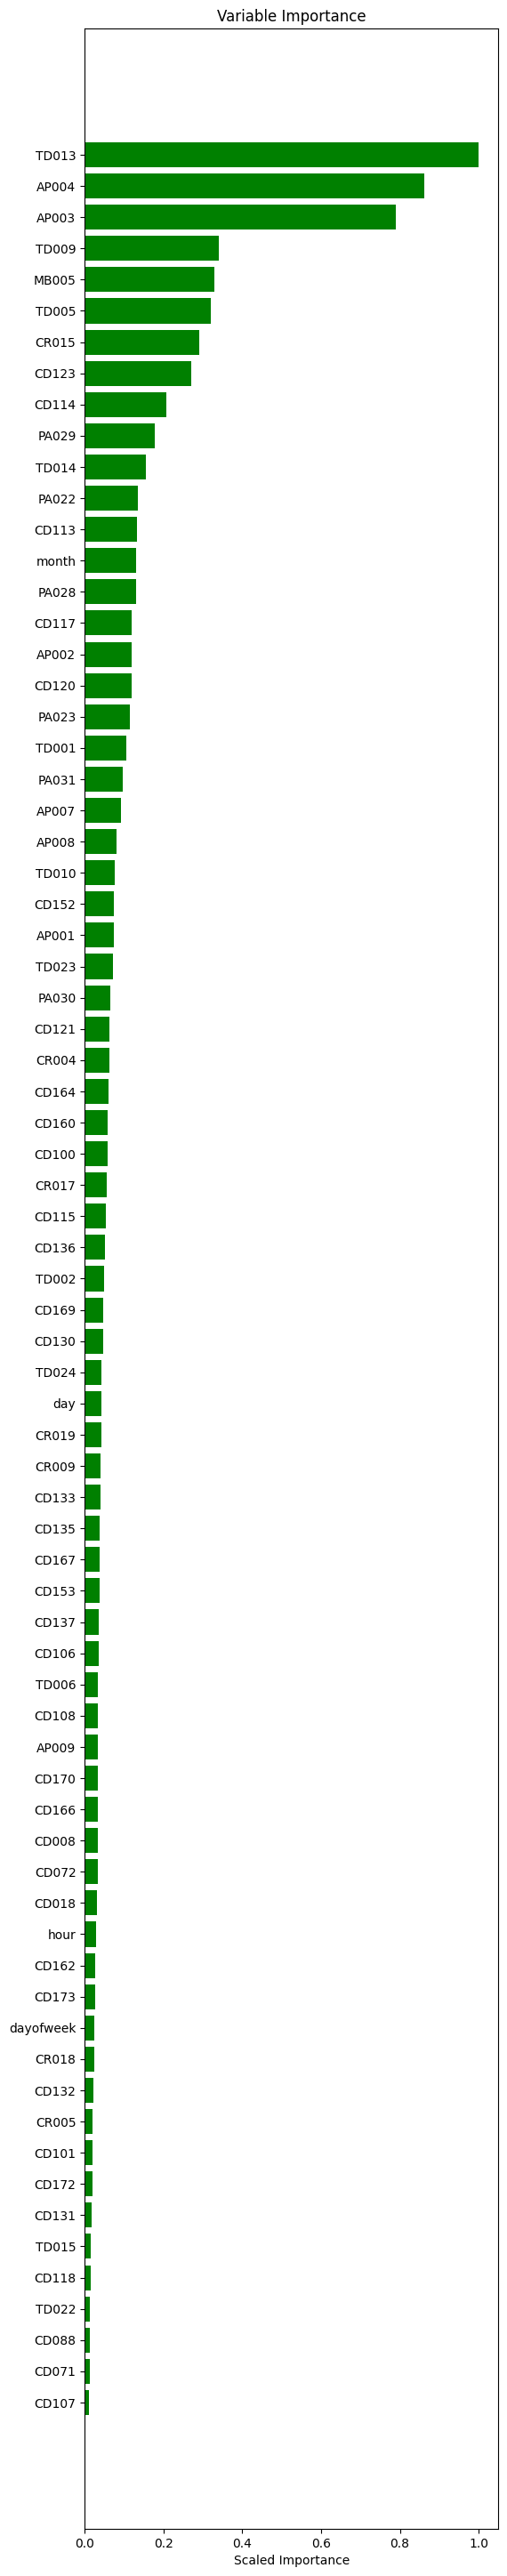

In [243]:
VarImp(gbm_v1)

In [244]:
createGains(gbm_v1)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1320,1880,3200,1320,1880,0.21,0.07,616.2,2.14,14.0,41.25
1,3200,1020,2180,6400,2340,4060,0.38,0.16,1232.4,1.90,22.0,36.56
2,3200,816,2384,9600,3156,6444,0.51,0.25,1848.6,1.71,26.0,32.88
3,3200,743,2457,12800,3899,8901,0.63,0.34,2464.8,1.58,29.0,30.46
4,3200,589,2611,16000,4488,11512,0.73,0.45,3081.0,1.46,28.0,28.05
5,3200,525,2675,19200,5013,14187,0.81,0.55,3697.2,1.36,26.0,26.11
6,3200,407,2793,22400,5420,16980,0.88,0.66,4313.4,1.26,22.0,24.20
7,3200,334,2866,25600,5754,19846,0.93,0.77,4929.6,1.17,16.0,22.48
8,3200,252,2948,28800,6006,22794,0.97,0.88,5545.8,1.08,9.0,20.85


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



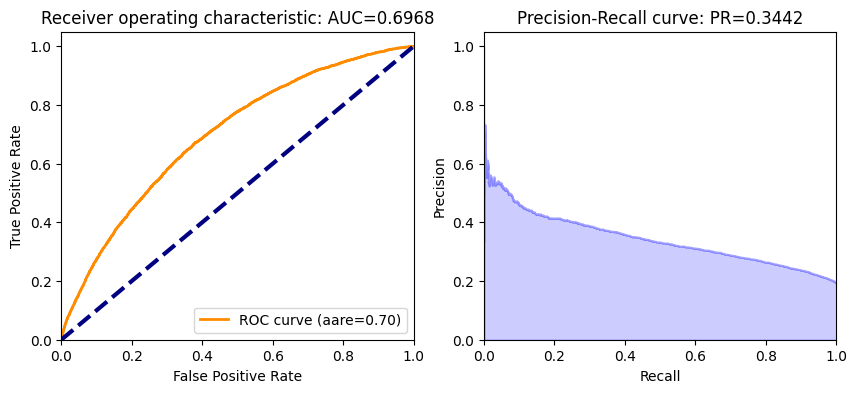

In [245]:
ROC_AUC(gbm_v1,test_hex,'loan_default')

#### Model 2: using all the engineered features

In [33]:
target = 'loan_default'
predictors = features2

In [34]:
gbm_v2 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v2',
        seed=414)
gbm_v2.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [AP009_D_WOE, TD027_D_WOE, TD026_D_WOE, AP002_D_WOE, TD028_D_WOE, TD025_D_WOE, CR012_D_WOE, TD029_D_WOE]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_v2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22720.0,5.0,5.0,5.0,29.0,32.0,31.5




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.13847680871079504
RMSE: 0.3721247219828253
MAE: 0.2859356376593399
RMSLE: 0.26005534361995275
Mean Residual Deviance: 0.13847680871079504

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-11-27 19:19:21,0.014 sec,0.0,0.395654,0.313085,0.156542
1,,2021-11-27 19:19:22,0.201 sec,1.0,0.393883,0.311613,0.155144
2,,2021-11-27 19:19:22,0.321 sec,2.0,0.392355,0.310243,0.153942
3,,2021-11-27 19:19:22,0.418 sec,3.0,0.391057,0.308993,0.152925
4,,2021-11-27 19:19:22,0.535 sec,4.0,0.389931,0.307847,0.152046
5,,2021-11-27 19:19:22,0.654 sec,5.0,0.388959,0.306780,0.151289
6,,2021-11-27 19:19:22,0.769 sec,6.0,0.388052,0.305779,0.150584
7,,2021-11-27 19:19:22,0.852 sec,7.0,0.387204,0.304836,0.149927
8,,2021-11-27 19:19:22,0.944 sec,8.0,0.386460,0.303966,0.149351
9,,2021-11-27 19:19:22,1.052 sec,9.0,0.385792,0.303158,0.148835



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013_D_WOE,619.821716,1.000000,0.135808
1,AP004_D_WOE,493.299194,0.795873,0.108086
2,AP003_D_WOE,231.660706,0.373754,0.050759
3,MB005_D_WOE,173.479691,0.279886,0.038011
4,CR015_D_WOE,157.581253,0.254236,0.034527
5,CD123_D_WOE,149.706055,0.241531,0.032802
6,TD009_D_WOE,144.575287,0.233253,0.031678
7,TD005_D_WOE,131.390244,0.211981,0.028789
8,PA028_D_WOE,112.469521,0.181455,0.024643
9,PA022_D_WOE,96.342621,0.155436,0.021110



See the whole table with table.as_data_frame()


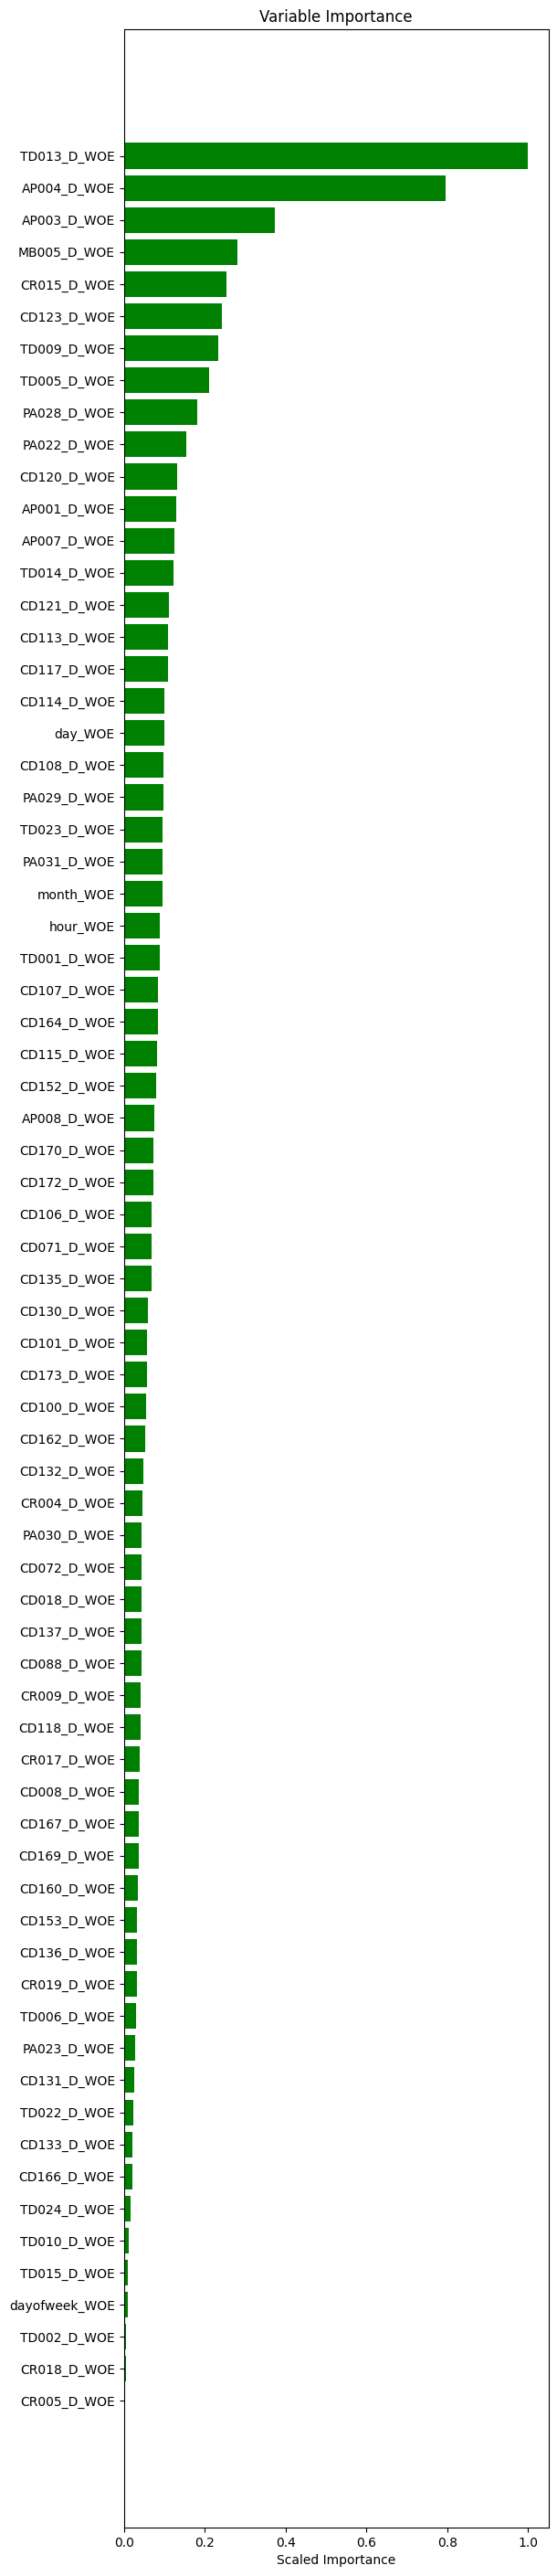

In [35]:
VarImp(gbm_v2)

In [36]:
createGains(gbm_v2)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1267,1933,3200,1267,1933,0.21,0.07,616.2,2.06,14.0,39.59
1,3200,979,2221,6400,2246,4154,0.36,0.16,1232.4,1.82,20.0,35.09
2,3200,841,2359,9600,3087,6513,0.50,0.25,1848.6,1.67,25.0,32.16
3,3200,676,2524,12800,3763,9037,0.61,0.35,2464.8,1.53,26.0,29.40
4,3200,615,2585,16000,4378,11622,0.71,0.45,3081.0,1.42,26.0,27.36
5,3200,573,2627,19200,4951,14249,0.80,0.55,3697.2,1.34,25.0,25.79
6,3200,405,2795,22400,5356,17044,0.87,0.66,4313.4,1.24,21.0,23.91
7,3200,361,2839,25600,5717,19883,0.93,0.77,4929.6,1.16,16.0,22.33
8,3200,279,2921,28800,5996,22804,0.97,0.88,5545.8,1.08,9.0,20.82


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



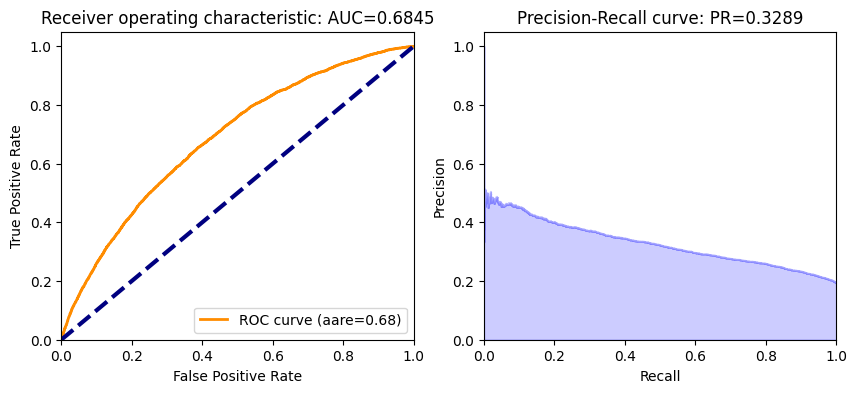

In [37]:
ROC_AUC(gbm_v2,test_hex,'loan_default')

#### Model 3: using mixture of raw and engineered features

In [38]:
target = 'loan_default'
predictors = features[1:]+features2

In [39]:
gbm_v3 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v3',
        seed=414)
gbm_v3.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [AP009_D_WOE, TD027_D_WOE, TD026_D_WOE, AP002_D_WOE, CR012, TD029, TD028, TD028_D_WOE, TD027, TD026, TD025_D_WOE, CR012_D_WOE, TD025, TD029_D_WOE]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_v3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22167.0,5.0,5.0,5.0,21.0,32.0,30.58




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.1364239875433723
RMSE: 0.36935617978229673
MAE: 0.2829927382693386
RMSLE: 0.258045687796371
Mean Residual Deviance: 0.1364239875433723

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-11-27 19:19:28,0.000 sec,0.0,0.395654,0.313085,0.156542
1,,2021-11-27 19:19:28,0.164 sec,1.0,0.393656,0.311424,0.154965
2,,2021-11-27 19:19:28,0.284 sec,2.0,0.391974,0.309919,0.153643
3,,2021-11-27 19:19:28,0.398 sec,3.0,0.390524,0.308531,0.152509
4,,2021-11-27 19:19:28,0.538 sec,4.0,0.389289,0.307250,0.151546
5,,2021-11-27 19:19:28,0.656 sec,5.0,0.388174,0.306051,0.150679
6,,2021-11-27 19:19:28,0.785 sec,6.0,0.387157,0.304945,0.149890
7,,2021-11-27 19:19:28,0.901 sec,7.0,0.386222,0.303925,0.149168
8,,2021-11-27 19:19:29,1.017 sec,8.0,0.385383,0.302919,0.148520
9,,2021-11-27 19:19:29,1.125 sec,9.0,0.384561,0.301976,0.147887



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,AP003,440.394653,1.000000,0.086635
1,TD013_D_WOE,342.860870,0.778531,0.067448
2,AP004,312.018097,0.708497,0.061381
3,TD013,274.916412,0.624250,0.054082
4,AP004_D_WOE,201.705154,0.458010,0.039680
5,TD005,160.280487,0.363947,0.031531
6,TD009,127.057373,0.288508,0.024995
7,CR015,112.836739,0.256217,0.022197
8,MB005_D_WOE,103.516014,0.235053,0.020364
9,CD123,103.389824,0.234766,0.020339



See the whole table with table.as_data_frame()


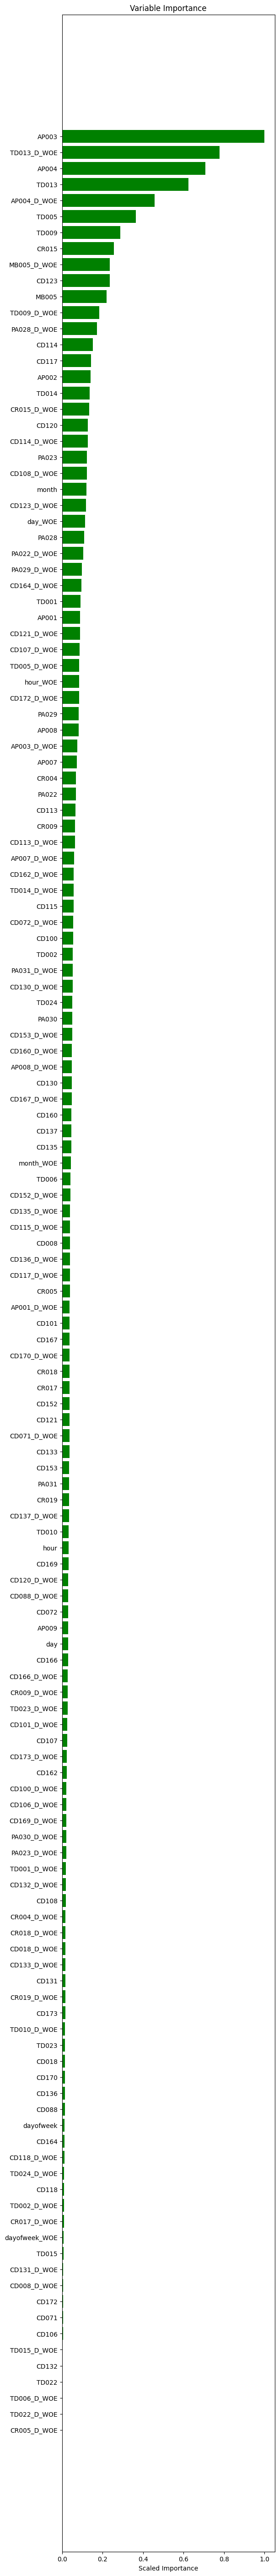

In [40]:
VarImp(gbm_v3)

In [41]:
createGains(gbm_v3)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1306,1894,3200,1306,1894,0.21,0.07,616.2,2.12,14.0,40.81
1,3200,1037,2163,6400,2343,4057,0.38,0.16,1232.4,1.90,22.0,36.61
2,3200,823,2377,9600,3166,6434,0.51,0.25,1848.6,1.71,26.0,32.98
3,3200,680,2520,12800,3846,8954,0.62,0.35,2464.8,1.56,27.0,30.05
4,3200,613,2587,16000,4459,11541,0.72,0.45,3081.0,1.45,27.0,27.87
5,3200,510,2690,19200,4969,14231,0.81,0.55,3697.2,1.34,26.0,25.88
6,3200,437,2763,22400,5406,16994,0.88,0.66,4313.4,1.25,22.0,24.13
7,3200,343,2857,25600,5749,19851,0.93,0.77,4929.6,1.17,16.0,22.46
8,3200,258,2942,28800,6007,22793,0.97,0.88,5545.8,1.08,9.0,20.86


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



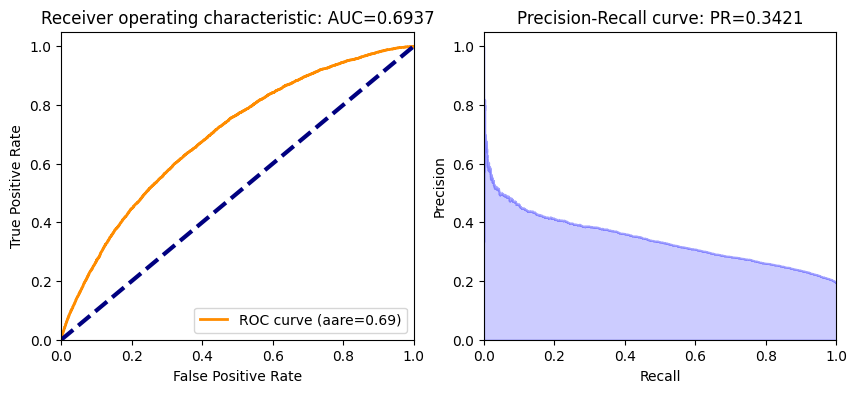

In [42]:
ROC_AUC(gbm_v3,test_hex,'loan_default')

### Analysing variables from various models

In [43]:
def delete_dict(dic,limit):
    l=[]
    for i,j in dic.items():
        if j>=limit:
            l.append(i)
    return l

In [44]:
def get_importance(gbm):
    scaled_importance = list(gbm._model_json['output']['variable_importances']['scaled_importance'])
    variables = list(gbm._model_json['output']['variable_importances']['variable'])
    res = dict(zip(variables,scaled_importance))
    return res

In [45]:
var1 = set(delete_dict(get_importance(gbm_v1),0.10))
var2 = set(delete_dict(get_importance(gbm_v2),0.10))
var3 = set(delete_dict(get_importance(gbm_v3),0.10))

In [46]:
var1.union(var2,var3)

{'AP001_D_WOE',
 'AP002',
 'AP003',
 'AP003_D_WOE',
 'AP004',
 'AP004_D_WOE',
 'AP007_D_WOE',
 'CD108_D_WOE',
 'CD113',
 'CD113_D_WOE',
 'CD114',
 'CD114_D_WOE',
 'CD117',
 'CD117_D_WOE',
 'CD120',
 'CD120_D_WOE',
 'CD121_D_WOE',
 'CD123',
 'CD123_D_WOE',
 'CR015',
 'CR015_D_WOE',
 'MB005',
 'MB005_D_WOE',
 'PA022',
 'PA022_D_WOE',
 'PA023',
 'PA028',
 'PA028_D_WOE',
 'PA029',
 'TD001',
 'TD005',
 'TD005_D_WOE',
 'TD009',
 'TD009_D_WOE',
 'TD013',
 'TD013_D_WOE',
 'TD014',
 'TD014_D_WOE',
 'day_WOE',
 'month'}

### Model 4: using mixture of select features

In [47]:
target = 'loan_default'
predictors = ['AP001_D_WOE',
 'AP002',
 'AP003','AP003_D_WOE',
 'AP004','AP004_D_WOE',
 'AP007_D_WOE',
 'CD108_D_WOE',
 'CD113','CD113_D_WOE',
 'CD114','CD114_D_WOE',
 'CD117','CD117_D_WOE',
 'CD120','CD120_D_WOE',
 'CD121_D_WOE',
 'CD123','CD123_D_WOE',
 'CR015','CR015_D_WOE',
 'MB005','MB005_D_WOE',
 'PA022','PA022_D_WOE',
 'PA023',
 'PA028','PA028_D_WOE',
 'PA029',
 'TD001',
 'TD005','TD005_D_WOE',
 'TD009','TD009_D_WOE',
 'TD013','TD013_D_WOE',
 'TD014','TD014_D_WOE',
 'day_WOE',
 'month']

In [48]:
gbm_v4 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v4',
        seed=414)
gbm_v4.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_v4


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22166.0,5.0,5.0,5.0,22.0,32.0,30.6




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.13873696813218658
RMSE: 0.37247411739903025
MAE: 0.2849631366375094
RMSLE: 0.2605663812513924
Mean Residual Deviance: 0.13873696813218658

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-11-27 19:19:36,0.017 sec,0.0,0.395654,0.313085,0.156542
1,,2021-11-27 19:19:36,0.065 sec,1.0,0.393665,0.311432,0.154972
2,,2021-11-27 19:19:36,0.093 sec,2.0,0.391999,0.309939,0.153663
3,,2021-11-27 19:19:36,0.126 sec,3.0,0.390570,0.308565,0.152545
4,,2021-11-27 19:19:36,0.167 sec,4.0,0.389338,0.307284,0.151584
5,,2021-11-27 19:19:37,0.199 sec,5.0,0.388225,0.306085,0.150718
6,,2021-11-27 19:19:37,0.233 sec,6.0,0.387216,0.304979,0.149937
7,,2021-11-27 19:19:37,0.264 sec,7.0,0.386332,0.303990,0.149252
8,,2021-11-27 19:19:37,0.294 sec,8.0,0.385518,0.303003,0.148624
9,,2021-11-27 19:19:37,0.342 sec,9.0,0.384742,0.302074,0.148026



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013_D_WOE,465.784088,1.000000,0.103538
1,AP003,445.234436,0.955882,0.098970
2,AP004,392.199677,0.842020,0.087181
3,TD013,170.679794,0.366435,0.037940
4,TD005,168.808517,0.362418,0.037524
5,CD123,161.292160,0.346281,0.035853
6,TD009_D_WOE,143.977646,0.309108,0.032004
7,AP004_D_WOE,136.960632,0.294043,0.030445
8,MB005_D_WOE,124.841652,0.268025,0.027751
9,MB005,118.463264,0.254331,0.026333



See the whole table with table.as_data_frame()


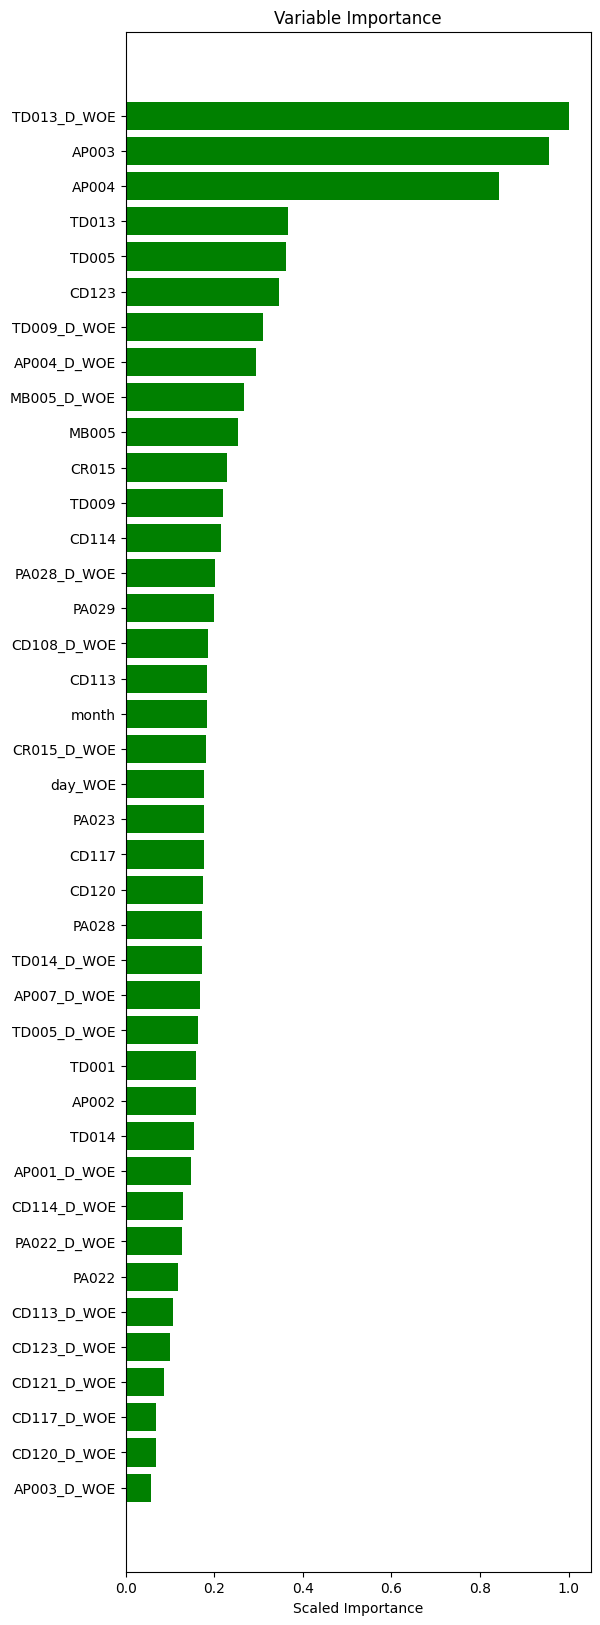

In [49]:
VarImp(gbm_v4)

In [50]:
createGains(gbm_v4)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1286,1914,3200,1286,1914,0.21,0.07,616.2,2.09,14.0,40.19
1,3200,1021,2179,6400,2307,4093,0.37,0.16,1232.4,1.87,21.0,36.05
2,3200,837,2363,9600,3144,6456,0.51,0.25,1848.6,1.70,26.0,32.75
3,3200,726,2474,12800,3870,8930,0.63,0.35,2464.8,1.57,28.0,30.23
4,3200,611,2589,16000,4481,11519,0.73,0.45,3081.0,1.45,28.0,28.01
5,3200,498,2702,19200,4979,14221,0.81,0.55,3697.2,1.35,26.0,25.93
6,3200,395,2805,22400,5374,17026,0.87,0.66,4313.4,1.25,21.0,23.99
7,3200,354,2846,25600,5728,19872,0.93,0.77,4929.6,1.16,16.0,22.38
8,3200,279,2921,28800,6007,22793,0.97,0.88,5545.8,1.08,9.0,20.86


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



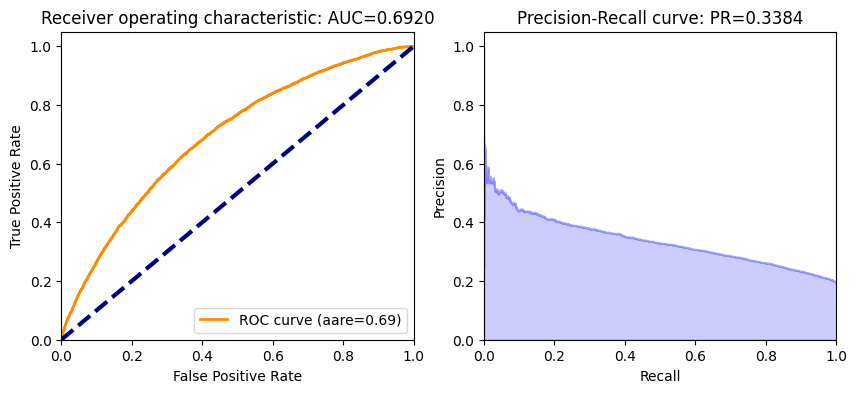

In [51]:
ROC_AUC(gbm_v4,test_hex,'loan_default')

## AutoML

The Automatic Machine Learning (AutoML) function automates the supervised machine learning model training process. The current version of AutoML trains and cross-validates the following algorithms (in the following order): three pre-specified XGBoost GBM (Gradient Boosting Machine) models, a fixed grid of GLMs, a default Random Forest (DRF), five pre-specified H2O GBMs, a near-default Deep Neural Net, an Extremely Randomized Forest (XRT), a random grid of XGBoost GBMs, a random grid of H2O GBMs, and a random grid of Deep Neural Nets. In some cases, there will not be enough time to complete all the algorithms, so some may be missing from the leaderboard. AutoML trains several Stacked Ensemble models during the run. Two kinds of Stacked Ensemble models are trained one of all available models, and one of only the best models of each kind. Note that Stacked Ensemble models are trained only if there isn’t another stacked ensemble with the same base models.

### Model 1: using 10% of the data data set

In [52]:
from h2o.automl import H2OAutoML

In [53]:
target = 'loan_default'
predictors = ['AP001','AP002','AP003','AP004','AP007','AP008','AP009','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014','TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029','CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','PA022','PA023','PA028','PA029','PA030','PA031','CD008','CD018','CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113','CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131','CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164','CD166','CD167','CD169','CD170','CD172','CD173','MB005','hour','dayofweek','day','month']

In [54]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [55]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v1 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1)
aml_v1.train(predictors,target,training_frame=train_hex)

AutoML progress: |
19:19:44.671: AutoML: XGBoost is not available; skipping it.
19:19:44.693: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
19:19:44.693: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20211127_191944

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.11224724258162729
RMSE: 0.3350331962382643
MAE: 0.2565120166399836
RMSLE: 0.2317376200982581
R^2: 0.2849355465416321
Mean Residual Deviance: 0.11224724258162729
Null degrees of freedom: 4799
Residual degrees of freedom: 4794
Null deviance: 753.4800000000133
Residual deviance: 538.786764391811
AIC: 3137.9635941127085

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.

In [56]:
aml_v1.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_1_AutoML_1_20211127_191944,0.146009,0.382111,0.146009,0.293008,0.268319
StackedEnsemble_AllModels_2_AutoML_1_20211127_191944,0.14606,0.382178,0.14606,0.292871,0.26833
StackedEnsemble_BestOfFamily_2_AutoML_1_20211127_191944,0.146292,0.382482,0.146292,0.293987,0.268588
StackedEnsemble_BestOfFamily_1_AutoML_1_20211127_191944,0.146364,0.382575,0.146364,0.294279,0.268662
StackedEnsemble_BestOfFamily_3_AutoML_1_20211127_191944,0.146523,0.382783,0.146523,0.293932,0.268798
GLM_1_AutoML_1_20211127_191944,0.1469,0.383275,0.1469,0.296484,0.269298
GBM_1_AutoML_1_20211127_191944,0.147874,0.384544,0.147874,0.294028,0.26981
GBM_grid_1_AutoML_1_20211127_191944_model_2,0.14794,0.38463,0.14794,0.296017,0.269753
GBM_grid_1_AutoML_1_20211127_191944_model_3,0.149508,0.386662,0.149508,0.295865,0.271499
GBM_2_AutoML_1_20211127_191944,0.149748,0.386973,0.149748,0.295184,0.272096


In [57]:
pred = aml_v1.predict(test_hex)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
0.268846
0.160452
0.0846269
0.231388
0.194889
0.109521
0.114818
0.122594
0.129942
0.343434


In [58]:
perf = aml_v1.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.1451043944597279
RMSE: 0.3809257072707589
MAE: 0.2899130656250575
RMSLE: 0.2676206372066335
R^2: 0.06303445999755719
Mean Residual Deviance: 0.1451043944597279
Null degrees of freedom: 3199
Residual degrees of freedom: 3194
Null deviance: 495.6100000000081
Residual deviance: 464.33406227112926
AIC: 2918.2407442907142


In [59]:
createGains(aml_v1)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,122,198,320,122,198,0.20,0.08,61.3,1.99,12.0,38.12
1,320,104,216,640,226,414,0.37,0.16,122.6,1.84,21.0,35.31
2,320,88,232,960,314,646,0.51,0.25,183.9,1.71,26.0,32.71
3,320,70,250,1280,384,896,0.63,0.35,245.2,1.57,28.0,30.00
4,320,58,262,1600,442,1158,0.72,0.45,306.5,1.44,27.0,27.62
5,320,47,273,1920,489,1431,0.80,0.55,367.8,1.33,25.0,25.47
6,320,37,283,2240,526,1714,0.86,0.66,429.1,1.23,20.0,23.48
7,320,37,283,2560,563,1997,0.92,0.77,490.4,1.15,15.0,21.99
8,320,35,285,2880,598,2282,0.98,0.88,551.7,1.08,10.0,20.76


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



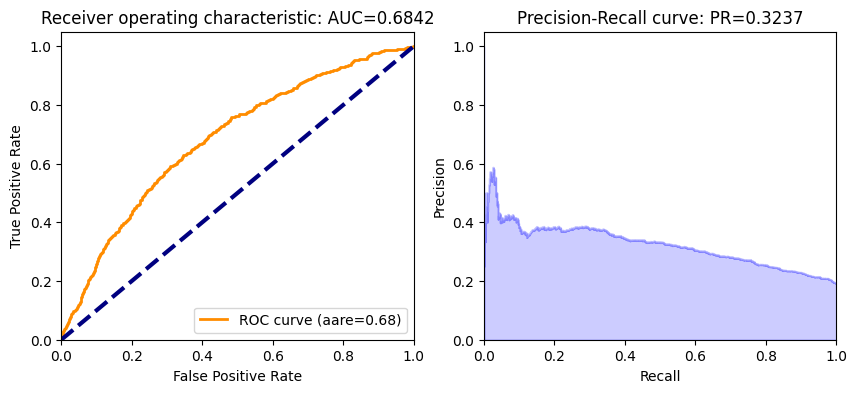

In [60]:
ROC_AUC(aml_v1,test_hex,'loan_default')

### Model 2: using the entire data set

In [61]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [62]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v2 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1)
aml_v2.train(predictors,target,training_frame=train_hex)

AutoML progress: |
19:21:15.235: AutoML: XGBoost is not available; skipping it.
19:21:15.235: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
19:21:15.235: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_2_20211127_192115

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.1287046978804335
RMSE: 0.35875436984158604
MAE: 0.2740220330664916
RMSLE: 0.2497704002028373
R^2: 0.18196474904225624
Mean Residual Deviance: 0.1287046978804335
Null degrees of freedom: 9974
Residual degrees of freedom: 9968
Null deviance: 1569.422702734375
Residual deviance: 1283.8293613573242
AIC: 7872.732979207314

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0

In [63]:
aml_v2.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_1_AutoML_2_20211127_192115,0.144438,0.380051,0.144438,0.2909,0.266933
StackedEnsemble_BestOfFamily_2_AutoML_2_20211127_192115,0.144494,0.380123,0.144494,0.291198,0.267027
StackedEnsemble_BestOfFamily_1_AutoML_2_20211127_192115,0.144499,0.380131,0.144499,0.29125,0.267036
GLM_1_AutoML_2_20211127_192115,0.145465,0.381399,0.145465,0.294862,0.268218
GBM_1_AutoML_2_20211127_192115,0.145789,0.381823,0.145789,0.289636,0.268241
GBM_2_AutoML_2_20211127_192115,0.148804,0.385751,0.148804,0.302014,0.26989
GBM_3_AutoML_2_20211127_192115,0.149718,0.386934,0.149718,0.303901,0.270812
GBM_4_AutoML_2_20211127_192115,0.151152,0.388782,0.151152,0.305902,0.272242
DRF_1_AutoML_2_20211127_192115,0.190422,0.436374,0.190422,0.299473,0.312985


In [64]:
lb2 = aml_v2.leaderboard.head()
for i in range(9):
    print(i)
    m = h2o.get_model(lb2[i,"model_id"])
    print(m.varimp(use_pandas=True))

0
None
1
None
2
None
3
     variable  relative_importance  scaled_importance  percentage
0       AP003             0.047652           1.000000    0.063535
1       AP004             0.044859           0.941388    0.059811
2       CD114             0.028939           0.607300    0.038585
3       TD013             0.028549           0.599110    0.038064
4       CD117             0.025888           0.543274    0.034517
..        ...                  ...                ...         ...
68       hour             0.000701           0.014707    0.000934
69      CD153             0.000548           0.011510    0.000731
70      CD018             0.000336           0.007042    0.000447
71      TD022             0.000313           0.006572    0.000418
72  dayofweek             0.000061           0.001274    0.000081

[73 rows x 4 columns]
4
   variable  relative_importance  scaled_importance  percentage
0     TD013           705.861084           1.000000    0.074278
1     AP004           428.084991

In [65]:
pred = aml_v2.predict(test_hex)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
0.0240868
0.124399
0.373216
0.254642
0.364323
0.172777
0.273154
0.0657175
0.383606
0.0999837


In [66]:
perf = aml_v2.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.1437487343414934
RMSE: 0.3791421030978931
MAE: 0.2893779606728041
RMSLE: 0.2663446103073083
R^2: 0.07546491167704572
Mean Residual Deviance: 0.1437487343414934
Null degrees of freedom: 31999
Residual degrees of freedom: 31993
Null deviance: 4975.5255555554595
Residual deviance: 4599.959498927789
AIC: 28758.037199519753


In [67]:
createGains(aml_v2)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1297,1903,3200,1297,1903,0.21,0.07,616.2,2.10,14.0,40.53
1,3200,1030,2170,6400,2327,4073,0.38,0.16,1232.4,1.89,22.0,36.36
2,3200,834,2366,9600,3161,6439,0.51,0.25,1848.6,1.71,26.0,32.93
3,3200,718,2482,12800,3879,8921,0.63,0.35,2464.8,1.57,28.0,30.30
4,3200,588,2612,16000,4467,11533,0.72,0.45,3081.0,1.45,27.0,27.92
5,3200,524,2676,19200,4991,14209,0.81,0.55,3697.2,1.35,26.0,25.99
6,3200,432,2768,22400,5423,16977,0.88,0.66,4313.4,1.26,22.0,24.21
7,3200,348,2852,25600,5771,19829,0.94,0.77,4929.6,1.17,17.0,22.54
8,3200,254,2946,28800,6025,22775,0.98,0.88,5545.8,1.09,10.0,20.92


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



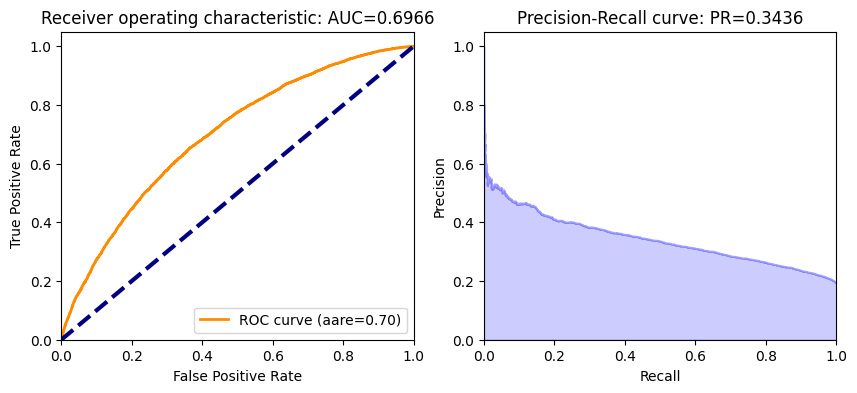

In [68]:
ROC_AUC(aml_v2,test_hex,'loan_default')

### Model 3: using all the engineered features

In [69]:
target = 'loan_default'
predictors = features2

In [70]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v3 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1)
aml_v3.train(predictors,target,training_frame=train_hex)

AutoML progress: |
19:22:20.104: AutoML: XGBoost is not available; skipping it.
19:22:20.104: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
19:22:20.104: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_2_AutoML_3_20211127_192220

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.13439085543948914
RMSE: 0.3665935834674267
MAE: 0.28185107817913724
RMSLE: 0.25587197167501935
R^2: 0.1468164931873548
Mean Residual Deviance: 0.13439085543948914
Null degrees of freedom: 9974
Residual degrees of freedom: 9971
Null deviance: 1571.2569527343749
Residual deviance: 1340.5487830089041
AIC: 8297.969878833945

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **



In [71]:
aml_v3.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_2_AutoML_3_20211127_192220,0.145484,0.381424,0.145484,0.292882,0.267916
StackedEnsemble_AllModels_1_AutoML_3_20211127_192220,0.145487,0.381428,0.145487,0.292837,0.267912
StackedEnsemble_BestOfFamily_1_AutoML_3_20211127_192220,0.145496,0.381439,0.145496,0.292903,0.26793
GLM_1_AutoML_3_20211127_192220,0.146097,0.382226,0.146097,0.295574,0.26862
GBM_1_AutoML_3_20211127_192220,0.1468,0.383144,0.1468,0.291962,0.269115
GBM_2_AutoML_3_20211127_192220,0.150423,0.387844,0.150423,0.304675,0.271472
GBM_3_AutoML_3_20211127_192220,0.151052,0.388653,0.151052,0.305793,0.272103
GBM_4_AutoML_3_20211127_192220,0.15215,0.390064,0.15215,0.307472,0.273225
DRF_1_AutoML_3_20211127_192220,0.219388,0.468389,0.219388,0.305635,0.336305


In [72]:
lb3 = aml_v3.leaderboard.head()
for i in range(9):
    print(i)
    m = h2o.get_model(lb3[i,"model_id"])
    print(m.varimp(use_pandas=True))

0
None
1
None
2
None
3
       variable  relative_importance  scaled_importance  percentage
0   AP004_D_WOE             0.041183           1.000000    0.086137
1   TD013_D_WOE             0.027027           0.656257    0.056528
2   AP003_D_WOE             0.025007           0.607205    0.052303
3   MB005_D_WOE             0.020184           0.490109    0.042216
4   CR015_D_WOE             0.017791           0.431994    0.037210
..          ...                  ...                ...         ...
66  CR009_D_WOE             0.000409           0.009922    0.000855
67  CD166_D_WOE             0.000303           0.007362    0.000634
68  CD135_D_WOE             0.000289           0.007026    0.000605
69  CD088_D_WOE             0.000210           0.005102    0.000439
70  CD160_D_WOE             0.000015           0.000356    0.000031

[71 rows x 4 columns]
4
       variable  relative_importance  scaled_importance  percentage
0   TD013_D_WOE           576.122498           1.000000    0.063653


In [73]:
pred = aml_v3.predict(test_hex)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
0.0329512
0.209194
0.417277
0.220833
0.273748
0.211418
0.258967
0.140494
0.314666
0.060446


In [74]:
perf = aml_v3.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.14482661690093443
RMSE: 0.38056092403310987
MAE: 0.2914505237425642
RMSLE: 0.2673915561758259
R^2: 0.06853239674493394
Mean Residual Deviance: 0.14482661690093443
Null degrees of freedom: 31999
Residual degrees of freedom: 31996
Null deviance: 4975.5255555554595
Residual deviance: 4634.451740829902
AIC: 28991.0902036133


In [75]:
createGains(aml_v3)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1289,1911,3200,1289,1911,0.21,0.07,616.2,2.09,14.0,40.28
1,3200,974,2226,6400,2263,4137,0.37,0.16,1232.4,1.84,21.0,35.36
2,3200,856,2344,9600,3119,6481,0.51,0.25,1848.6,1.69,26.0,32.49
3,3200,727,2473,12800,3846,8954,0.62,0.35,2464.8,1.56,27.0,30.05
4,3200,594,2606,16000,4440,11560,0.72,0.45,3081.0,1.44,27.0,27.75
5,3200,497,2703,19200,4937,14263,0.80,0.55,3697.2,1.34,25.0,25.71
6,3200,428,2772,22400,5365,17035,0.87,0.66,4313.4,1.24,21.0,23.95
7,3200,352,2848,25600,5717,19883,0.93,0.77,4929.6,1.16,16.0,22.33
8,3200,284,2916,28800,6001,22799,0.97,0.88,5545.8,1.08,9.0,20.84


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



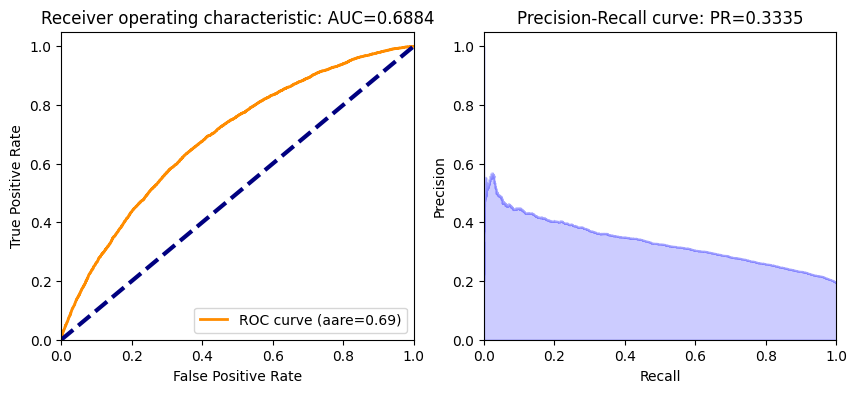

In [76]:
ROC_AUC(aml_v3,test_hex,'loan_default')

### Model 3: using mixture of raw and engineered features

In [77]:
target = 'loan_default'
predictors = features[1:]+features2

In [78]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v4 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1)
aml_v4.train(predictors,target,training_frame=train_hex)

AutoML progress: |
19:23:25.128: AutoML: XGBoost is not available; skipping it.
19:23:25.128: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
19:23:25.128: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_4_20211127_192325

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.13610648125772648
RMSE: 0.36892611896926797
MAE: 0.28283644631754007
RMSLE: 0.2580543483628213
R^2: 0.13491969301637818
Mean Residual Deviance: 0.13610648125772648
Null degrees of freedom: 9974
Residual degrees of freedom: 9970
Null deviance: 1569.422702734375
Residual deviance: 1357.6621505458215
AIC: 8426.504189488234

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE

In [79]:
aml_v4.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_1_AutoML_4_20211127_192325,0.144062,0.379555,0.144062,0.291494,0.266801
StackedEnsemble_BestOfFamily_2_AutoML_4_20211127_192325,0.144063,0.379556,0.144063,0.291546,0.266818
StackedEnsemble_BestOfFamily_1_AutoML_4_20211127_192325,0.144076,0.379573,0.144076,0.291554,0.266827
GLM_1_AutoML_4_20211127_192325,0.144373,0.379964,0.144373,0.293491,0.267276
GBM_1_AutoML_4_20211127_192325,0.146202,0.382364,0.146202,0.294254,0.268046
GBM_2_AutoML_4_20211127_192325,0.152043,0.389927,0.152043,0.307607,0.272995
GBM_3_AutoML_4_20211127_192325,0.153272,0.391499,0.153272,0.309267,0.274239
GBM_4_AutoML_4_20211127_192325,0.154486,0.393047,0.154486,0.310736,0.275494
DRF_1_AutoML_4_20211127_192325,0.286865,0.535597,0.286865,0.303717,0.371521


In [80]:
pred = aml_v4.predict(test_hex)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
0.0309767
0.156148
0.388061
0.31269
0.343483
0.220352
0.278425
0.102738
0.362161
0.0718701


In [81]:
perf = aml_v4.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.1429543780768992
RMSE: 0.3780930812338401
MAE: 0.289401074604304
RMSLE: 0.2657857701581089
R^2: 0.08057389745428267
Mean Residual Deviance: 0.1429543780768992
Null degrees of freedom: 31999
Residual degrees of freedom: 31995
Null deviance: 4975.5255555554595
Residual deviance: 4574.540098460774
AIC: 28576.71463544089


In [82]:
createGains(aml_v4)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1371,1829,3200,1371,1829,0.22,0.07,616.2,2.22,15.0,42.84
1,3200,1032,2168,6400,2403,3997,0.39,0.15,1232.4,1.95,24.0,37.55
2,3200,822,2378,9600,3225,6375,0.52,0.25,1848.6,1.74,27.0,33.59
3,3200,690,2510,12800,3915,8885,0.64,0.34,2464.8,1.59,30.0,30.59
4,3200,619,2581,16000,4534,11466,0.74,0.44,3081.0,1.47,30.0,28.34
5,3200,515,2685,19200,5049,14151,0.82,0.55,3697.2,1.37,27.0,26.30
6,3200,417,2783,22400,5466,16934,0.89,0.66,4313.4,1.27,23.0,24.40
7,3200,313,2887,25600,5779,19821,0.94,0.77,4929.6,1.17,17.0,22.57
8,3200,246,2954,28800,6025,22775,0.98,0.88,5545.8,1.09,10.0,20.92


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



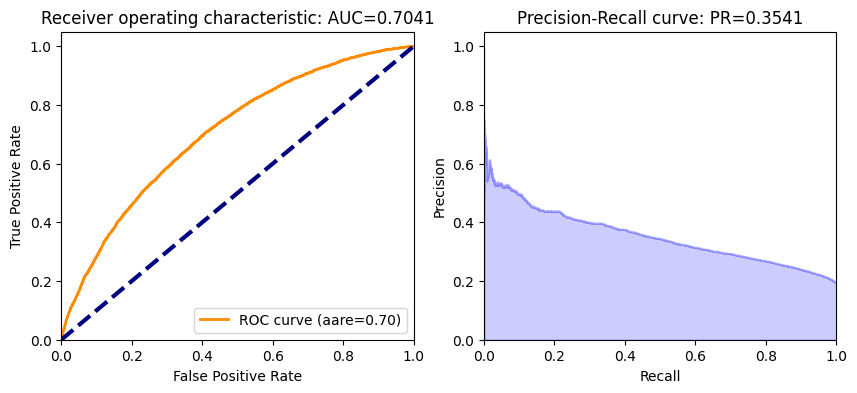

In [83]:
ROC_AUC(aml_v4,test_hex,'loan_default')

### Model 4: using mixture of select features

In [84]:
target = 'loan_default'
predictors = ['AP001_D_WOE',
 'AP002',
 'AP003','AP003_D_WOE',
 'AP004','AP004_D_WOE',
 'AP007_D_WOE',
 'CD108_D_WOE',
 'CD113','CD113_D_WOE',
 'CD114','CD114_D_WOE',
 'CD117','CD117_D_WOE',
 'CD120','CD120_D_WOE',
 'CD121_D_WOE',
 'CD123','CD123_D_WOE',
 'CR015','CR015_D_WOE',
 'MB005','MB005_D_WOE',
 'PA022','PA022_D_WOE',
 'PA023',
 'PA028','PA028_D_WOE',
 'PA029',
 'TD001',
 'TD005','TD005_D_WOE',
 'TD009','TD009_D_WOE',
 'TD013','TD013_D_WOE',
 'TD014','TD014_D_WOE',
 'day_WOE',
 'month']

In [85]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v5 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1)
aml_v5.train(predictors,target,training_frame=train_hex)

AutoML progress: |
19:24:28.645: AutoML: XGBoost is not available; skipping it.
19:24:28.645: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
19:24:28.645: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_5_20211127_192428

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.13383944982815135
RMSE: 0.36584074380548615
MAE: 0.2790568090902014
RMSLE: 0.2553826427893346
R^2: 0.14932873678061143
Mean Residual Deviance: 0.13383944982815135
Null degrees of freedom: 9974
Residual degrees of freedom: 9968
Null deviance: 1569.422702734375
Residual deviance: 1335.0485120358098
AIC: 8262.958265954303

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE:

In [86]:
aml_v5.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_1_AutoML_5_20211127_192428,0.144562,0.380213,0.144562,0.290932,0.267041
StackedEnsemble_BestOfFamily_3_AutoML_5_20211127_192428,0.144592,0.380253,0.144592,0.290782,0.267065
StackedEnsemble_BestOfFamily_2_AutoML_5_20211127_192428,0.144693,0.380385,0.144693,0.291822,0.267241
StackedEnsemble_BestOfFamily_1_AutoML_5_20211127_192428,0.144702,0.380397,0.144702,0.291728,0.267262
GLM_1_AutoML_5_20211127_192428,0.14518,0.381026,0.14518,0.294563,0.267916
GBM_2_AutoML_5_20211127_192428,0.145753,0.381776,0.145753,0.293579,0.267537
GBM_1_AutoML_5_20211127_192428,0.145777,0.381808,0.145777,0.290557,0.267995
DeepLearning_1_AutoML_5_20211127_192428,0.146367,0.382579,0.146367,0.287035,0.267639
GBM_3_AutoML_5_20211127_192428,0.146424,0.382653,0.146424,0.294436,0.268217
GBM_4_AutoML_5_20211127_192428,0.147145,0.383594,0.147145,0.295583,0.268969


In [87]:
pred = aml_v5.predict(test_hex)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
0.0242046
0.192732
0.344802
0.307606
0.351075
0.15561
0.319195
0.0786449
0.348501
0.0490759


In [88]:
perf = aml_v5.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.14390208068199536
RMSE: 0.3793442772495657
MAE: 0.2892736758926902
RMSLE: 0.26649492654409923
R^2: 0.0744786485762996
Mean Residual Deviance: 0.14390208068199536
Null degrees of freedom: 31999
Residual degrees of freedom: 31993
Null deviance: 4975.5255555554595
Residual deviance: 4604.866581823851
AIC: 28792.15553400469


In [89]:
createGains(aml_v5)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1304,1896,3200,1304,1896,0.21,0.07,616.2,2.12,14.0,40.75
1,3200,1012,2188,6400,2316,4084,0.38,0.16,1232.4,1.88,22.0,36.19
2,3200,874,2326,9600,3190,6410,0.52,0.25,1848.6,1.73,27.0,33.23
3,3200,690,2510,12800,3880,8920,0.63,0.35,2464.8,1.57,28.0,30.31
4,3200,604,2596,16000,4484,11516,0.73,0.45,3081.0,1.46,28.0,28.02
5,3200,484,2716,19200,4968,14232,0.81,0.55,3697.2,1.34,26.0,25.87
6,3200,441,2759,22400,5409,16991,0.88,0.66,4313.4,1.25,22.0,24.15
7,3200,353,2847,25600,5762,19838,0.94,0.77,4929.6,1.17,17.0,22.51
8,3200,254,2946,28800,6016,22784,0.98,0.88,5545.8,1.08,10.0,20.89


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



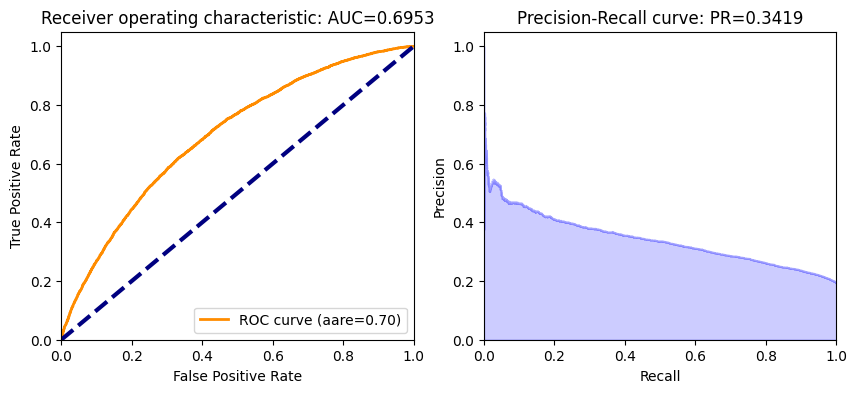

In [90]:
ROC_AUC(aml_v5,test_hex,'loan_default')

## H2o's Deep Learning (Neural Networks) Module
H2O’s Deep Learning is based on a multi-layer feedforward artificial neural network that is trained with stochastic gradient descent using back-propagation. The network can contain a large number of hidden layers consisting of neurons with tanh, rectifier, and maxout activation functions. Advanced features such as adaptive learning rate, rate annealing, momentum training, dropout, L1 or L2 regularization, checkpointing, and grid search enable high predictive accuracy. Each compute node trains a copy of the global model parameters on its local data with multi-threading (asynchronously) and contributes periodically to the global model via model averaging across the network.

A feedforward artificial neural network (ANN) model, also known as deep neural network (DNN) or multi-layer perceptron (MLP), is the most common type of Deep Neural Network and the only type that is supported natively in H2O-3. Several other types of DNNs are popular as well, such as Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs). MLPs work well on transactional (tabular) data; however if you have image data, then CNNs are a great choice. If you have sequential data (e.g. text, audio, time-series), then RNNs are a good choice.

#### Model 0: using 10%of the data

In [ ]:
target = 'loan_default'
predictors = ['AP001','AP002','AP003','AP004','AP007','AP008','AP009','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014','TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029','CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','PA022','PA023','PA028','PA029','PA030','PA031','CD008','CD018','CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113','CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131','CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164','CD166','CD167','CD169','CD170','CD172','CD173','MB005','hour','dayofweek','day','month']

In [107]:
train, test = train_test_split(df, test_size=0.40, random_state=414)
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [108]:
from h2o.estimators import H2ODeepLearningEstimator


In [248]:
d0 = H2ODeepLearningEstimator()
d0.train(x=predictors,
          y=target,
          training_frame=train_hex)

deeplearning Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [TD029, TD028, TD027, TD026, TD025, CR012]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1638058700392_45


Status of Neuron Layers: predicting loan_default, regression, gaussian distribution, Quadratic loss, 55,201 weights/biases, 666.9 KB, 480,000 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,73,Input,0.0,,,,,,,,,
1,,2,200,Rectifier,0.0,0.0,0.0,0.008746,0.004168,0.0,-0.008197,0.186342,0.209752,0.222401
2,,3,200,Rectifier,0.0,0.0,0.0,0.016916,0.023231,0.0,-0.02881,0.088967,0.936549,0.051659
3,,4,1,Linear,,0.0,0.0,0.000349,0.000174,0.0,-0.000726,0.087694,0.288105,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.1334162634353788
RMSE: 0.3652619107371843
MAE: 0.27719692677315955
RMSLE: 0.2561797600371289
Mean Residual Deviance: 0.1334162634353788

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2021-11-27 20:56:26,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2021-11-27 20:56:31,5.388 sec,9758 obs/sec,1.0,1,48000.0,0.382408,0.146236,0.283953,0.076238
2,,2021-11-27 20:56:39,13.075 sec,11722 obs/sec,3.0,3,144000.0,0.378326,0.143131,0.295370,0.095851
3,,2021-11-27 20:56:46,20.164 sec,12559 obs/sec,5.0,5,240000.0,0.376892,0.142048,0.280230,0.102693
4,,2021-11-27 20:56:53,27.348 sec,12922 obs/sec,7.0,7,336000.0,0.373564,0.139550,0.285494,0.118470
5,,2021-11-27 20:57:01,35.268 sec,12853 obs/sec,9.0,9,432000.0,0.371709,0.138168,0.272930,0.127203
6,,2021-11-27 20:57:06,39.692 sec,12723 obs/sec,10.0,10,480000.0,0.365262,0.133416,0.277197,0.157217



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,AP004,1.000000,1.000000,0.040091
1,AP003,0.658604,0.658604,0.026404
2,AP002,0.510554,0.510554,0.020469
3,CR015,0.475313,0.475313,0.019056
4,MB005,0.439387,0.439387,0.017616
5,month,0.426404,0.426404,0.017095
6,AP008,0.424566,0.424566,0.017021
7,CR004,0.416428,0.416428,0.016695
8,AP009,0.410135,0.410135,0.016443
9,CD113,0.402704,0.402704,0.016145



See the whole table with table.as_data_frame()


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



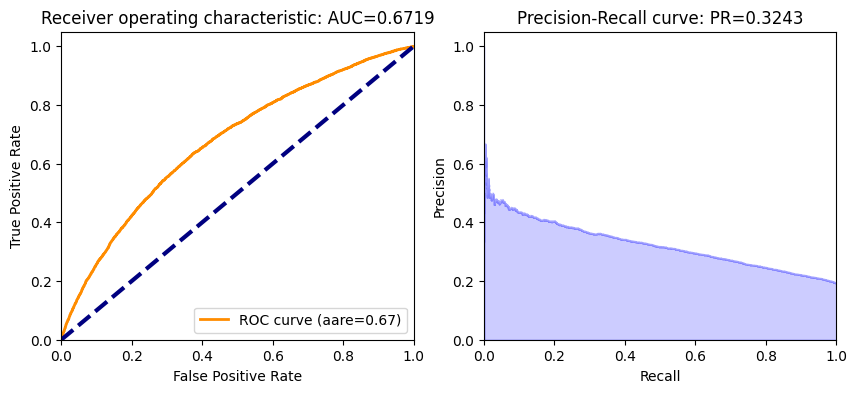

In [249]:
perf = d0.model_performance()
pred = d0.predict(test_hex)
ROC_AUC(d0,test_hex,'loan_default')

In [250]:
createGains(d0)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1270,1930,3200,1270,1930,0.21,0.07,616.2,2.06,14.0,39.69
1,3200,974,2226,6400,2244,4156,0.36,0.16,1232.4,1.82,20.0,35.06
2,3200,799,2401,9600,3043,6557,0.49,0.25,1848.6,1.65,24.0,31.70
3,3200,701,2499,12800,3744,9056,0.61,0.35,2464.8,1.52,26.0,29.25
4,3200,578,2622,16000,4322,11678,0.70,0.45,3081.0,1.40,25.0,27.01
5,3200,483,2717,19200,4805,14395,0.78,0.56,3697.2,1.30,22.0,25.03
6,3200,421,2779,22400,5226,17174,0.85,0.66,4313.4,1.21,19.0,23.33
7,3200,369,2831,25600,5595,20005,0.91,0.77,4929.6,1.13,14.0,21.86
8,3200,335,2865,28800,5930,22870,0.96,0.89,5545.8,1.07,7.0,20.59


### Model 1: Using all the Data

In [141]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [193]:
target = 'loan_default'
predictors = ['AP001','AP002','AP003','AP004','AP007','AP008','AP009','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014','TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029','CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','PA022','PA023','PA028','PA029','PA030','PA031','CD008','CD018','CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113','CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131','CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164','CD166','CD167','CD169','CD170','CD172','CD173','MB005','hour','dayofweek','day','month']

In [206]:
d1 = H2ODeepLearningEstimator(activation = 'Rectifier',hidden = [75,25,25,25],epochs = 10,seed = 414)
d1.train(x=predictors,y=target,training_frame=train_hex)

deeplearning Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [TD029, TD028, TD027, TD026, TD025, CR012]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1638058700392_35


Status of Neuron Layers: predicting loan_default, regression, gaussian distribution, Quadratic loss, 8,776 weights/biases, 121.1 KB, 480,000 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,73,Input,0.0,,,,,,,,,
1,,2,75,Rectifier,0.0,0.0,0.0,0.010169,0.006039,0.0,-0.001803,0.214434,0.274317,0.249633
2,,3,25,Rectifier,0.0,0.0,0.0,0.00363,0.001898,0.0,-0.021173,0.179846,0.959855,0.067696
3,,4,25,Rectifier,0.0,0.0,0.0,0.003966,0.003097,0.0,-0.024558,0.210202,0.951366,0.060519
4,,5,25,Rectifier,0.0,0.0,0.0,0.010804,0.015137,0.0,-0.060361,0.204004,0.883601,0.099073
5,,6,1,Linear,,0.0,0.0,0.000694,0.000359,0.0,-0.017826,0.113142,0.305074,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.13894755526927016
RMSE: 0.37275669714878384
MAE: 0.27028717577771166
RMSLE: 0.25902838142356366
Mean Residual Deviance: 0.13894755526927016

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2021-11-27 20:34:13,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2021-11-27 20:34:14,1.609 sec,31725 obs/sec,1.0,1,48000.0,0.379717,0.144185,0.274462,0.070671
2,,2021-11-27 20:34:20,6.739 sec,36385 obs/sec,5.0,5,240000.0,0.375800,0.141226,0.275418,0.089746
3,,2021-11-27 20:34:25,12.510 sec,38967 obs/sec,10.0,10,480000.0,0.372757,0.138948,0.270287,0.104430



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,AP004,1.000000,1.000000,0.039650
1,AP003,0.671628,0.671628,0.026630
2,AP002,0.536353,0.536353,0.021266
3,CR015,0.506779,0.506779,0.020094
4,month,0.463085,0.463085,0.018361
5,AP001,0.445457,0.445457,0.017662
6,AP007,0.444792,0.444792,0.017636
7,MB005,0.444502,0.444502,0.017624
8,CD106,0.440082,0.440082,0.017449
9,CD114,0.419544,0.419544,0.016635



See the whole table with table.as_data_frame()


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



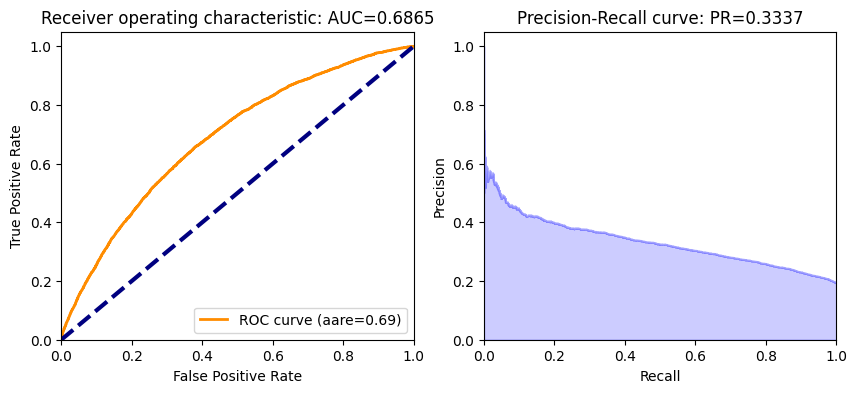

In [207]:
perf = d1.model_performance()
pred = d1.predict(test_hex)
ROC_AUC(d1,test_hex,'loan_default')

In [208]:
createGains(d1)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1267,1933,3200,1267,1933,0.21,0.07,616.2,2.06,14.0,39.59
1,3200,1014,2186,6400,2281,4119,0.37,0.16,1232.4,1.85,21.0,35.64
2,3200,835,2365,9600,3116,6484,0.51,0.25,1848.6,1.69,26.0,32.46
3,3200,705,2495,12800,3821,8979,0.62,0.35,2464.8,1.55,27.0,29.85
4,3200,602,2598,16000,4423,11577,0.72,0.45,3081.0,1.44,27.0,27.64
5,3200,522,2678,19200,4945,14255,0.80,0.55,3697.2,1.34,25.0,25.76
6,3200,427,2773,22400,5372,17028,0.87,0.66,4313.4,1.25,21.0,23.98
7,3200,318,2882,25600,5690,19910,0.92,0.77,4929.6,1.15,15.0,22.23
8,3200,294,2906,28800,5984,22816,0.97,0.88,5545.8,1.08,9.0,20.78


### Model 2: using all the engineered features

In [230]:
target = 'loan_default'
predictors = features2

In [237]:
d2 = H2ODeepLearningEstimator(activation = 'Rectifier',hidden = [75,25,25,25,5],seed = 414)
d2.train(x=predictors,y=target,training_frame=train_hex)

deeplearning Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [AP009_D_WOE, TD027_D_WOE, TD026_D_WOE, AP002_D_WOE, TD028_D_WOE, TD025_D_WOE, CR012_D_WOE, TD029_D_WOE]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1638058700392_44


Status of Neuron Layers: predicting loan_default, regression, gaussian distribution, Quadratic loss, 8,736 weights/biases, 121.8 KB, 480,000 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,71,Input,0.0,,,,,,,,,
1,,2,75,Rectifier,0.0,0.0,0.0,0.009056,0.004361,0.0,-0.003195,0.22318,0.267803,0.223488
2,,3,25,Rectifier,0.0,0.0,0.0,0.00515,0.003569,0.0,0.000396,0.194349,0.967343,0.049411
3,,4,25,Rectifier,0.0,0.0,0.0,0.004694,0.004386,0.0,-0.01329,0.228878,0.994261,0.036088
4,,5,25,Rectifier,0.0,0.0,0.0,0.015513,0.070357,0.0,-0.013746,0.21505,1.00115,0.047343
5,,6,5,Rectifier,0.0,0.0,0.0,0.034319,0.183307,0.0,-0.017149,0.265687,1.010488,0.049821
6,,7,1,Linear,,0.0,0.0,0.001037,0.001769,0.0,0.34508,0.314811,0.185557,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.1397843500787957
RMSE: 0.37387745329024014
MAE: 0.27073555540417793
RMSLE: 0.25980086932749163
Mean Residual Deviance: 0.1397843500787957

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2021-11-27 20:43:37,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2021-11-27 20:43:38,1.601 sec,31830 obs/sec,1.0,1,48000.0,0.381681,0.145680,0.265969,0.061034
2,,2021-11-27 20:43:43,6.681 sec,36708 obs/sec,5.0,5,240000.0,0.377828,0.142754,0.278275,0.079897
3,,2021-11-27 20:43:49,12.149 sec,40174 obs/sec,10.0,10,480000.0,0.373877,0.139784,0.270736,0.099036



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,AP004_D_WOE,1.000000,1.000000,0.040579
1,AP003_D_WOE,0.698295,0.698295,0.028336
2,CR015_D_WOE,0.533667,0.533667,0.021656
3,MB005_D_WOE,0.491844,0.491844,0.019958
4,month_WOE,0.470856,0.470856,0.019107
5,TD013_D_WOE,0.461306,0.461306,0.018719
6,hour_WOE,0.457607,0.457607,0.018569
7,AP001_D_WOE,0.456617,0.456617,0.018529
8,CR004_D_WOE,0.453656,0.453656,0.018409
9,AP008_D_WOE,0.440457,0.440457,0.017873



See the whole table with table.as_data_frame()


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



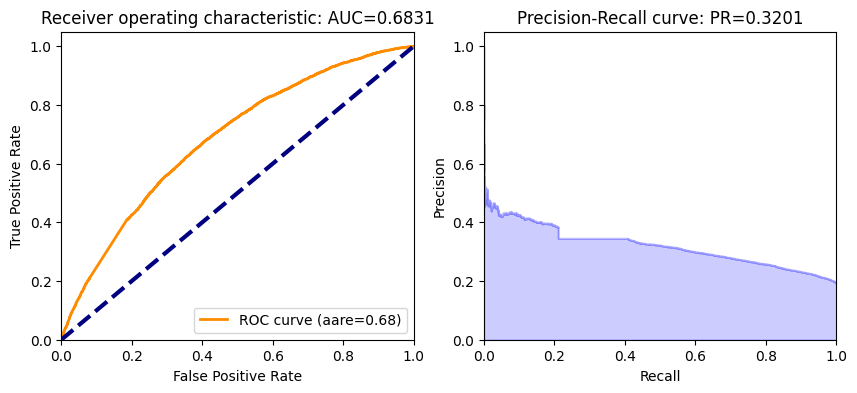

In [238]:
perf = d2.model_performance()
pred = d2.predict(test_hex)
ROC_AUC(d2,test_hex,'loan_default')

In [239]:
createGains(d2)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1241,1959,3200,1241,1959,0.20,0.08,616.2,2.01,12.0,38.78
1,3200,967,2233,6400,2208,4192,0.36,0.16,1232.4,1.79,20.0,34.50
2,3200,877,2323,9600,3085,6515,0.50,0.25,1848.6,1.67,25.0,32.14
3,3200,701,2499,12800,3786,9014,0.61,0.35,2464.8,1.54,26.0,29.58
4,3200,612,2588,16000,4398,11602,0.71,0.45,3081.0,1.43,26.0,27.49
5,3200,530,2670,19200,4928,14272,0.80,0.55,3697.2,1.33,25.0,25.67
6,3200,415,2785,22400,5343,17057,0.87,0.66,4313.4,1.24,21.0,23.85
7,3200,388,2812,25600,5731,19869,0.93,0.77,4929.6,1.16,16.0,22.39
8,3200,266,2934,28800,5997,22803,0.97,0.88,5545.8,1.08,9.0,20.82


### Model 3: using mixture of raw and engineered features

In [213]:
target = 'loan_default'
predictors = features[1:]+features2

In [217]:
d3 = H2ODeepLearningEstimator(activation = 'Rectifier',hidden = [72,24,24,24,4],seed = 414)
d3.train(x=predictors,y=target,training_frame=train_hex)

deeplearning Model Build progress: |

c:\users\varadharajan suresh\appdata\local\programs\python\python39\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [AP009_D_WOE, TD027_D_WOE, TD026_D_WOE, AP002_D_WOE, CR012, TD029, TD028, TD028_D_WOE, TD027, TD026, TD025_D_WOE, CR012_D_WOE, TD025, TD029_D_WOE]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1638058700392_38


Status of Neuron Layers: predicting loan_default, regression, gaussian distribution, Quadratic loss, 13,497 weights/biases, 187.6 KB, 480,000 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,144,Input,0.0,,,,,,,,,
1,,2,72,Rectifier,0.0,0.0,0.0,0.010416,0.004747,0.0,0.002069,0.202126,0.218566,0.310077
2,,3,24,Rectifier,0.0,0.0,0.0,0.003211,0.00204,0.0,-0.003259,0.192543,0.988344,0.086707
3,,4,24,Rectifier,0.0,0.0,0.0,0.004321,0.00459,0.0,0.006336,0.237085,1.014697,0.05669
4,,5,24,Rectifier,0.0,0.0,0.0,0.006481,0.023293,0.0,-0.018298,0.219538,0.998103,0.047326
5,,6,4,Rectifier,0.0,0.0,0.0,0.003863,0.004681,0.0,-0.014595,0.270837,1.000431,0.036314
6,,7,1,Linear,,0.0,0.0,0.000225,0.000118,0.0,0.248638,0.365725,0.141484,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.1357139821087696
RMSE: 0.3683937867401805
MAE: 0.27332002599827665
RMSLE: 0.2586338265298732
Mean Residual Deviance: 0.1357139821087696

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2021-11-27 20:38:01,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2021-11-27 20:38:03,2.292 sec,22566 obs/sec,1.0,1,48000.0,0.377551,0.142545,0.292713,0.081244
2,,2021-11-27 20:38:08,7.843 sec,25269 obs/sec,4.0,4,192000.0,0.375386,0.140915,0.275461,0.091752
3,,2021-11-27 20:38:13,13.052 sec,26386 obs/sec,7.0,7,336000.0,0.372378,0.138665,0.272538,0.106248
4,,2021-11-27 20:38:18,17.930 sec,27356 obs/sec,10.0,10,480000.0,0.368394,0.135714,0.273320,0.125271



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,AP004_D_WOE,1.000000,1.000000,0.017571
1,AP004,0.943138,0.943138,0.016572
2,AP003,0.878613,0.878613,0.015438
3,AP002,0.635354,0.635354,0.011164
4,CR015_D_WOE,0.632969,0.632969,0.011122
5,AP003_D_WOE,0.625878,0.625878,0.010998
6,hour,0.539346,0.539346,0.009477
7,MB005_D_WOE,0.530550,0.530550,0.009323
8,AP001,0.512976,0.512976,0.009014
9,CR018,0.512951,0.512951,0.009013



See the whole table with table.as_data_frame()


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



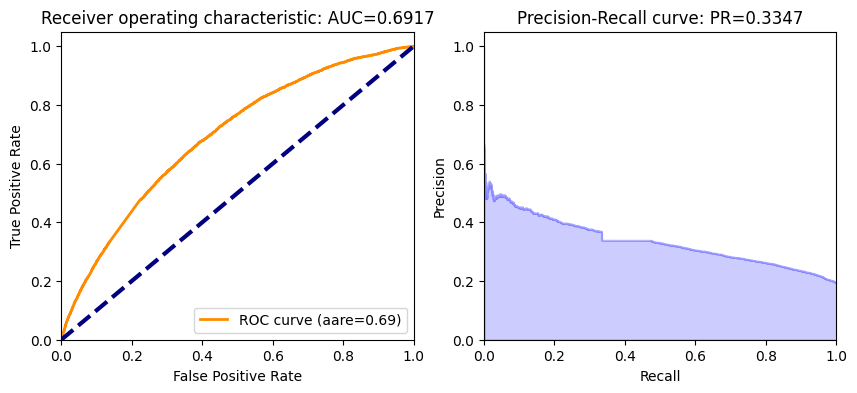

In [218]:
perf = d3.model_performance()
pred = d3.predict(test_hex)
ROC_AUC(d3,test_hex,'loan_default')

In [219]:
createGains(d3)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1291,1909,3200,1291,1909,0.21,0.07,616.2,2.10,14.0,40.34
1,3200,1016,2184,6400,2307,4093,0.37,0.16,1232.4,1.87,21.0,36.05
2,3200,833,2367,9600,3140,6460,0.51,0.25,1848.6,1.70,26.0,32.71
3,3200,707,2493,12800,3847,8953,0.62,0.35,2464.8,1.56,27.0,30.05
4,3200,609,2591,16000,4456,11544,0.72,0.45,3081.0,1.45,27.0,27.85
5,3200,534,2666,19200,4990,14210,0.81,0.55,3697.2,1.35,26.0,25.99
6,3200,404,2796,22400,5394,17006,0.88,0.66,4313.4,1.25,22.0,24.08
7,3200,357,2843,25600,5751,19849,0.93,0.77,4929.6,1.17,16.0,22.46
8,3200,230,2970,28800,5981,22819,0.97,0.88,5545.8,1.08,9.0,20.77


### Model 4: using mixture of select features

In [220]:
target = 'loan_default'
predictors = ['AP001_D_WOE',
 'AP002',
 'AP003','AP003_D_WOE',
 'AP004','AP004_D_WOE',
 'AP007_D_WOE',
 'CD108_D_WOE',
 'CD113','CD113_D_WOE',
 'CD114','CD114_D_WOE',
 'CD117','CD117_D_WOE',
 'CD120','CD120_D_WOE',
 'CD121_D_WOE',
 'CD123','CD123_D_WOE',
 'CR015','CR015_D_WOE',
 'MB005','MB005_D_WOE',
 'PA022','PA022_D_WOE',
 'PA023',
 'PA028','PA028_D_WOE',
 'PA029',
 'TD001',
 'TD005','TD005_D_WOE',
 'TD009','TD009_D_WOE',
 'TD013','TD013_D_WOE',
 'TD014','TD014_D_WOE',
 'day_WOE',
 'month']

In [224]:
d4 = H2ODeepLearningEstimator(activation = 'Rectifier',hidden = [20,10,5,10,20],seed = 414)
d4.train(x=predictors,y=target,training_frame=train_hex)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1638058700392_40


Status of Neuron Layers: predicting loan_default, regression, gaussian distribution, Quadratic loss, 1,386 weights/biases, 29.8 KB, 480,000 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,40,Input,0.0,,,,,,,,,
1,,2,20,Rectifier,0.0,0.0,0.0,0.007151,0.004641,0.0,0.004093,0.292368,0.508357,0.36638
2,,3,10,Rectifier,0.0,0.0,0.0,0.003661,0.001981,0.0,0.036465,0.310438,1.030075,0.186751
3,,4,5,Rectifier,0.0,0.0,0.0,0.002019,0.001524,0.0,-0.078642,0.400512,0.981271,0.05612
4,,5,10,Rectifier,0.0,0.0,0.0,0.009941,0.011604,0.0,-0.114379,0.332598,0.271592,0.249177
5,,6,20,Rectifier,0.0,0.0,0.0,0.061429,0.089269,0.0,-0.139631,0.286171,0.590943,0.16684
6,,7,1,Linear,,0.0,0.0,0.003298,0.003469,0.0,0.015024,0.112542,0.067978,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.142928623756079
RMSE: 0.37805902152452203
MAE: 0.27661236163206254
RMSLE: 0.2624151930304515
Mean Residual Deviance: 0.142928623756079

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2021-11-27 20:40:52,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2021-11-27 20:40:52,0.373 sec,154838 obs/sec,1.0,1,48000.0,0.380825,0.145028,0.309962,0.06524
2,,2021-11-27 20:40:54,2.739 sec,181200 obs/sec,10.0,10,480000.0,0.378059,0.142929,0.276612,0.07877



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,AP003,1.000000,1.000000,0.047058
1,AP004,0.902507,0.902507,0.042470
2,AP004_D_WOE,0.847715,0.847715,0.039892
3,CD113,0.725189,0.725189,0.034126
4,AP007_D_WOE,0.724137,0.724137,0.034077
5,CD123,0.676918,0.676918,0.031855
6,AP002,0.632632,0.632632,0.029771
7,CR015_D_WOE,0.627241,0.627241,0.029517
8,AP001_D_WOE,0.620387,0.620387,0.029194
9,CD114,0.605238,0.605238,0.028481



See the whole table with table.as_data_frame()


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



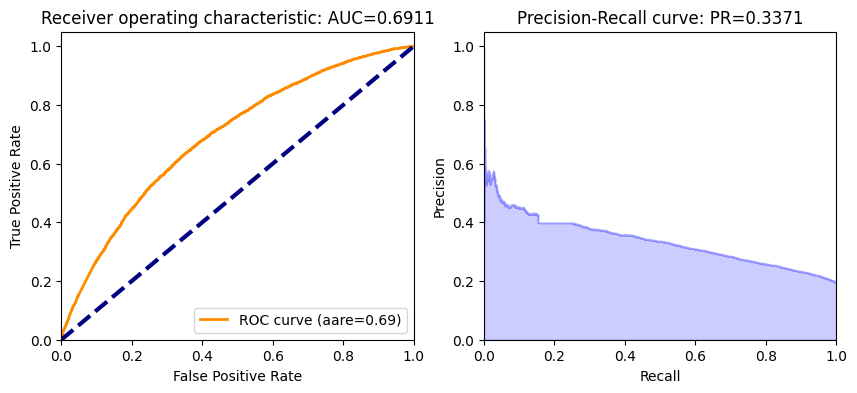

In [225]:
perf = d4.model_performance()
pred = d4.predict(test_hex)
ROC_AUC(d4,test_hex,'loan_default')

In [226]:
createGains(d4)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1293,1907,3200,1293,1907,0.21,0.07,616.2,2.10,14.0,40.41
1,3200,1017,2183,6400,2310,4090,0.37,0.16,1232.4,1.87,21.0,36.09
2,3200,869,2331,9600,3179,6421,0.52,0.25,1848.6,1.72,27.0,33.11
3,3200,690,2510,12800,3869,8931,0.63,0.35,2464.8,1.57,28.0,30.23
4,3200,563,2637,16000,4432,11568,0.72,0.45,3081.0,1.44,27.0,27.70
5,3200,502,2698,19200,4934,14266,0.80,0.55,3697.2,1.33,25.0,25.70
6,3200,433,2767,22400,5367,17033,0.87,0.66,4313.4,1.24,21.0,23.96
7,3200,361,2839,25600,5728,19872,0.93,0.77,4929.6,1.16,16.0,22.38
8,3200,268,2932,28800,5996,22804,0.97,0.88,5545.8,1.08,9.0,20.82


### Conclusion
We have tried various tuning of parameter and using different set of features as well. We have found the most optimal model for AutoML model 3 which has the AUC of 0.7041, Precision of 0.3543 and lift of 2.23.

* GBM: best performing model was model 3 which has the AUC of 0.6937, Precision of 0.3421 and lift of 2.12. 

* AutoML: best performing model was model 3 which has the AUC of 0.7041, Precision of 0.3543 and lift of 2.23.

* DeepLearning: best performing model was model 3 which has the AUC of 0.6917, Precision of 0.3347 and lift of 2.10. The model consumes 144 features and hidden layers of [72,24,24,24,4].


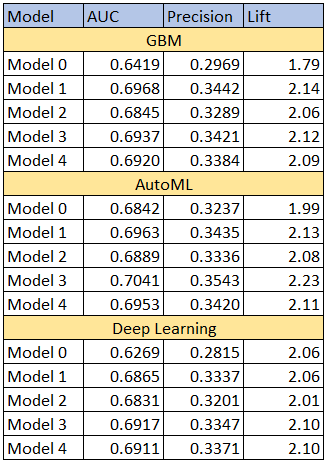